# **Milestone 2**

## **Mounting the Drive**

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import keras
model_3_128 = keras.models.load_model("/content/drive/MyDrive/model_3_128.h5")

## **Importing the Libraries**

In [4]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, Attention, AlphaDropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, experimental
!pip install -q -U tensorflow_addons
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import CyclicalLearningRate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.6 MB/s eta 0:00:00


In [5]:
def metrics_score(actual, predicted):

    from sklearn.metrics import classification_report

    from sklearn.metrics import confusion_matrix

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])

    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

## **Loading the data**

In [6]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **Data augmentation**

In [8]:
data_aug = ImageDataGenerator(
                              rotation_range=30, # I don't think we need to care about upside down faces
                              width_shift_range=0.1, 
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='constant', # don't want to introduce new confusing pixels
                              cval = 255 / 2,
                              brightness_range=[0.8,1.2],
                              rescale=1./255
                              )


img_size = 48

train_set_augmented = data_aug.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)
validation_set_augmented = data_aug.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale' ,
                                              class_mode = 'categorical',
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### Visualizing Augmented images

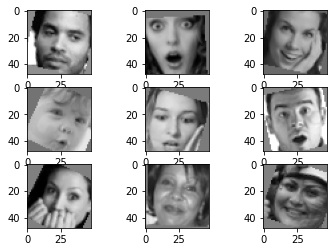

In [ ]:
import matplotlib.pyplot as plt

X, y = train_set_augmented.next()

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X[i].squeeze(), cmap='gray', vmin=0, vmax=1)

plt.show()


## **Baseline Architecture**

### **Model Building**

* In this network, we will have 3 Convolutional Blocks 
* First Conv2D block has one Conv2D layer with **128 filters** and a **kernel size of 5**. We use the 'same' padding and provide the **input shape = (48, 48, 1)** and we use **'relu' activation** and **he_normal** initialization.
  * The first layer uses 128 $5\times5$ filters  because the input images are not very large. It also sets input_shape=[48, 48, 1], because the images are 48 × 48 pixels, with a single color channel (i.e., grayscale).
  * Relu proved to be the best experimentally
  * Next we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2.
* Then we repeat the same structure twice: two convolutional layers followed by a max pooling layer. 
  * The number of filters grows as we climb up the CNN toward the output layer (it is initially 128, then 256, then 512) 
* Then comes the Flatten layer, followed by three Dense blocks consisting of a Dense layer followed by an **AlphaDropout** layer
* The first Dense layer has **256 neurons** and the second and third each have 128.


**This will be a baseline for future models**

In [ ]:
no_of_classes = 4
def build_model(dropout = 0):
  model = Sequential()
  # Add 1st CNN Block
  model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same', input_shape=(48, 48, 1), kernel_initializer = 'he_normal'))
  model.add(MaxPooling2D(2))

  # Add 2nd CNN Block
  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal'))
  model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal'))
  model.add(MaxPooling2D(2))

  # Add 3rd CNN Block
  model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal'))
  model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal'))
  model.add(MaxPooling2D(2))

  model.add(Flatten())

  # First fully connected layer
  model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal'))
  model.add(Dropout(dropout))

  # Second fully connected layer
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal'))
  model.add(Dropout(dropout))

  # Third fully connected layer
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal'))
  model.add(Dropout(dropout))

  model.add(Dense(4, activation = 'softmax'))
  return model

In [ ]:
from tensorflow.keras import backend

backend.clear_session()


### **Compiling and Training an initial Model**

In [ ]:
model1 = build_model(dropout = 0)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       295168    
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 512)       1

In [ ]:
model1.compile(optimizer = 'adam', 
               loss = 'categorical_crossentropy', 
               metrics = ['accuracy'])

#### Callbacks:

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping, Callback
from keras import backend
import math
K = backend
batch_size = 32
steps_per_epoch = len(train_set_augmented) // 32

validation_steps = len(validation_set_augmented)//32

epochs = 25

onecycle = OneCycleScheduler(math.ceil(len(train_set_augmented) / batch_size) * epochs, start_lr = .001, max_lr=0.005)

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True
                          )


checkpoint = ModelCheckpoint("model1.h5", 
                             monitor = 'val_accuracy',
                             save_weights_only = True, 
                             model = 'max', 
                             verbose = 1)

callbacks = [checkpoint, 
             early_stopping, 
             #onecycle
             ]

#### Fitting and evaluating:

In [ ]:
history = model1.fit(train_set_augmented, 
                     epochs=100, 
                     batch_size=32,
                     validation_data=validation_set_augmented,
                     callbacks=callbacks,
                     use_multiprocessing=True)

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.3097
Epoch 1: saving model to model1.h5
473/473 [==============================] - 17s 37ms/step - loss: 1.3572 - accuracy: 0.3097 - val_loss: 1.3311 - val_accuracy: 0.3349
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.3024 - accuracy: 0.3577
Epoch 2: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 1.3024 - accuracy: 0.3577 - val_loss: 1.2827 - val_accuracy: 0.3637
Epoch 3/100
472/473 [============================>.] - ETA: 0s - loss: 1.2424 - accuracy: 0.4003
Epoch 3: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 1.2426 - accuracy: 0.4000 - val_loss: 1.2078 - val_accuracy: 0.4095
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.4589
Epoch 4: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 1.1700 -

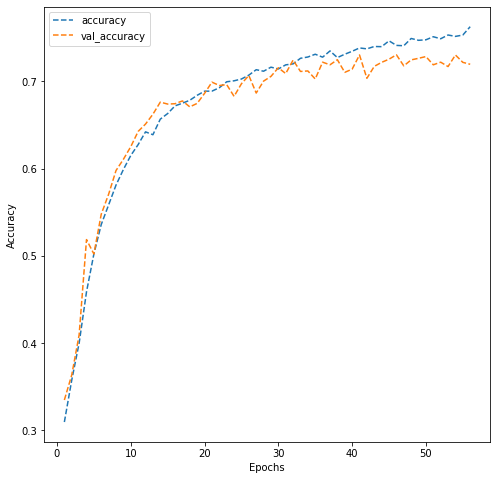

In [ ]:
dict_hist = history.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

#### Checkpoint:

In [ ]:
from keras import models
model1_clone = models.clone_model(model1)
model1_clone.set_weights(model1.get_weights())
# Need to compile and fit before saving
model1_clone.compile(optimizer = 'adam', 
               loss = 'categorical_crossentropy', 
               metrics = ['accuracy'])
model1_clone.fit(train_set_augmented,
                 epochs=1, 
                 batch_size=32,
                 validation_data=validation_set_augmented,
                 #callbacks=callbacks,
                 use_multiprocessing=True)
model1_clone.save("model1_clone_70percent_acc.h5")

473/473 [==============================] - 23s 47ms/step - loss: 0.7296 - accuracy: 0.7029 - val_loss: 0.7807 - val_accuracy: 0.7191


### **Evaluating the Model on Test Set**

In [22]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              batch_size = 128,
                                                              shuffle = True) 
#model1.evaluate(test_set)

Found 128 images belonging to 4 classes.


**Observations and Insights:**

*Not so good*

#### **Confusion Matrix:**

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        32
           1       0.17      0.16      0.16        32
           2       0.25      0.28      0.26        32
           3       0.96      0.69      0.80        32

    accuracy                           0.52       128
   macro avg       0.54      0.52      0.52       128
weighted avg       0.54      0.52      0.52       128



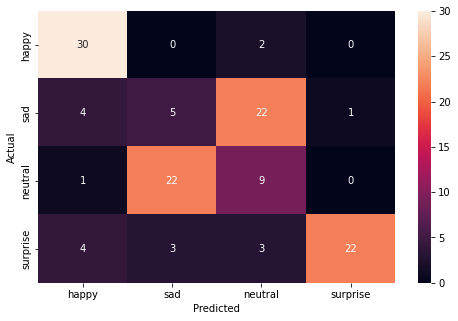

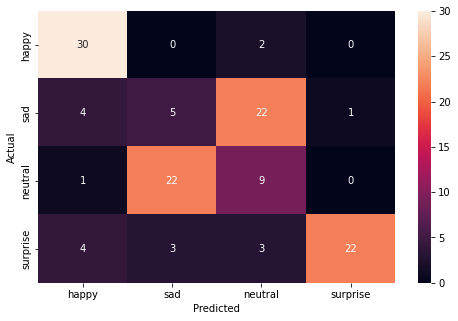

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_images, test_labels = next(test_set)

# Write the name of your chosen model in the blank
pred = model1.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
metrics_score(y_true, pred)

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['happy', 'sad', 'neutral', 'surprise'], yticklabels = ['happy', 'sad', 'neutral', 'surprise'])

4/4 [==============================] - 0s 3ms/step


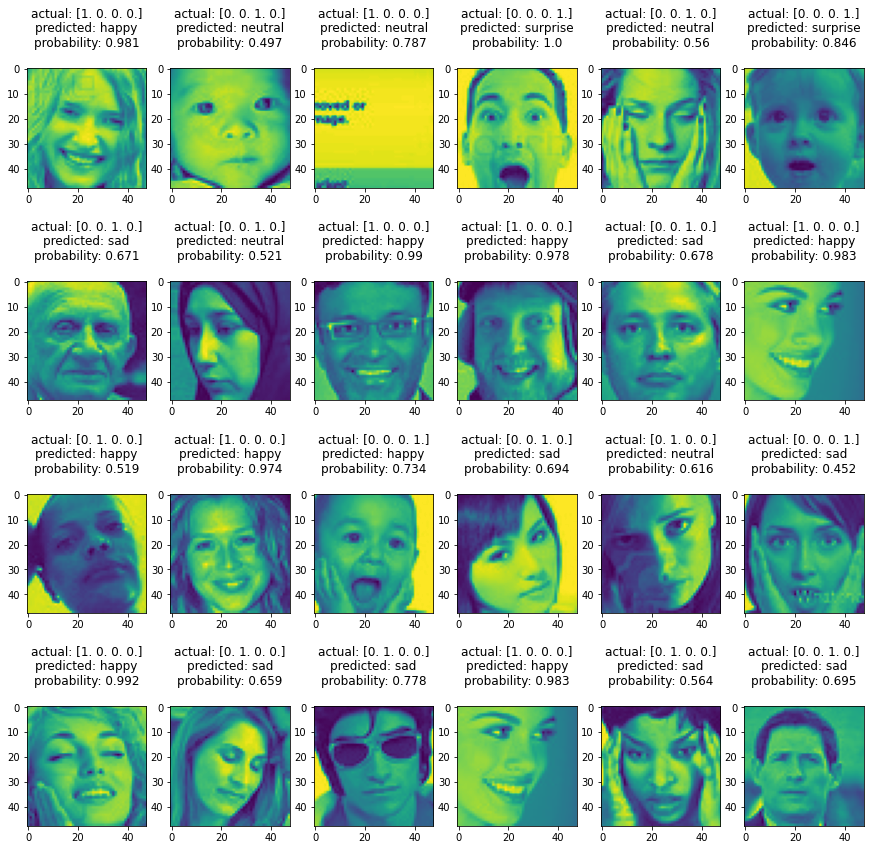

In [ ]:
rows = 4

cols = 6
class_names_list = ['happy', 'sad', 'neutral', 'surprise']
fig = plt.figure(figsize = (15, 15))

for i in range(cols):

    for j in range(rows):

        random_index = np.random.randint(0, len(test_labels))

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)

        ax.imshow(test_images[random_index, :].squeeze())

        pred_label = class_names_list[pred[random_index]]

        true_label = test_labels[random_index]

        y_pred_test_max_probas = np.max(model1.predict(test_images), axis = -1)

        pred_proba = y_pred_test_max_probas[random_index]

        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
        
plt.show()

**Observations and Insights:**

The model is confusing sad and neutral. (It is also confusing and sad). Lets refit the model and oversample neutral and sad.

In [ ]:
class_weight = {
                0: 1,
                1: 10,
                2: 10,
                3: 1
                }
early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True
                          )
checkpoint = ModelCheckpoint("./model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [ ]:
new_history = model1.fit(train_set_augmented,
                         initial_epoch = 56, 
                         epochs=100, 
                         batch_size=32,
                         validation_data=validation_set_augmented,
                         callbacks=callbacks,
                         use_multiprocessing=True,
                         class_weight = class_weight)

Epoch 57/100
472/473 [============================>.] - ETA: 0s - loss: 4.0338 - accuracy: 0.6111
Epoch 57: saving model to model1.h5
473/473 [==============================] - 17s 35ms/step - loss: 4.0354 - accuracy: 0.6113 - val_loss: 1.1315 - val_accuracy: 0.5905
Epoch 58/100
473/473 [==============================] - ETA: 0s - loss: 3.7761 - accuracy: 0.6484
Epoch 58: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 3.7761 - accuracy: 0.6484 - val_loss: 1.0480 - val_accuracy: 0.6209
Epoch 59/100
473/473 [==============================] - ETA: 0s - loss: 3.6938 - accuracy: 0.6577
Epoch 59: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 3.6938 - accuracy: 0.6577 - val_loss: 0.9740 - val_accuracy: 0.6351
Epoch 60/100
472/473 [============================>.] - ETA: 0s - loss: 3.6507 - accuracy: 0.6615
Epoch 60: saving model to model1.h5
473/473 [==============================] - 17s 36ms/step - loss: 

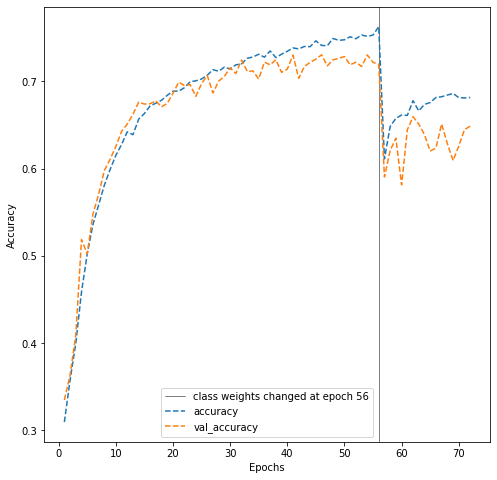

In [ ]:
import tensorflow.keras
# Concatenate the two histories along the epoch axis
merged_history = {key: np.concatenate((history.history[key], new_history.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history = tensorflow.keras.callbacks.History()
final_history.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
class_weights_changed_index = 56
plt.axvline(x=56, color='k', linestyle='-', label = 'class weights changed at epoch 56', lw=.5)

# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()


Clearly this hasn't had as much of an effect as we hoped it would. But its worth keeping the class weights like this going forward.

### Second Baseline Model: increasing complexity

In [ ]:
model2 = Sequential()
for i in range(0,8):
  model2.add(model1.layers[i])
  model2.layers[i].set_weights(model1.layers[i].get_weights())
model2.add(Conv2D(filters=1024, 
                  kernel_size=(5, 5), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer = 'he_normal'))
model2.add(Conv2D(filters=1024, 
                  kernel_size=(5, 5), 
                  activation='relu', 
                  padding='same', 
                  kernel_initializer = 'he_normal'))
model2.add(MaxPooling2D(2))
model2.add(model1.layers[8]) # Dense 512
model2.add(Dropout(0.4))
model2.add(Dense(128, 
                 activation = 'relu', 
                 kernel_initializer = 'he_normal'))
model2.add(AlphaDropout(0.4))
model2.add(Dense(128, 
                 activation = 'relu', 
                 kernel_initializer = 'he_normal'))
model2.add(AlphaDropout(0.4))
model2.add(Dense(4, 
                 activation = 'softmax'))


In [ ]:
model2.compile(optimizer = 'adamax', # determined experimentally later on in the nb to be better
                                     # I had to rerun this cell for various reasons so I figured 
                                     # I may as well apply the lessons learned later on. #shrug
               loss = 'categorical_crossentropy',
               metrics = ['accuracy', 
                          'Precision', 
                          'Recall'])

In [ ]:
new_history_2 = model2.fit(train_set_augmented,
                          epochs=24, 
                          batch_size=32,
                          validation_data=validation_set_augmented,
                          use_multiprocessing=True,
                          class_weight = class_weight)

Epoch 1/24
473/473 [==============================] - 18s 37ms/step - loss: 3.0364 - accuracy: 0.7269 - precision: 0.7581 - recall: 0.6949 - val_loss: 1.9212 - val_accuracy: 0.6695 - val_precision: 0.6719 - val_recall: 0.6653
Epoch 2/24
473/473 [==============================] - 17s 36ms/step - loss: 2.9910 - accuracy: 0.7319 - precision: 0.7604 - recall: 0.7000 - val_loss: 1.7737 - val_accuracy: 0.7030 - val_precision: 0.7064 - val_recall: 0.6982
Epoch 3/24
473/473 [==============================] - 17s 37ms/step - loss: 2.9370 - accuracy: 0.7413 - precision: 0.7685 - recall: 0.7151 - val_loss: 1.7672 - val_accuracy: 0.6970 - val_precision: 0.7005 - val_recall: 0.6956
Epoch 4/24
473/473 [==============================] - 17s 36ms/step - loss: 2.8964 - accuracy: 0.7432 - precision: 0.7713 - recall: 0.7146 - val_loss: 1.8353 - val_accuracy: 0.7135 - val_precision: 0.7182 - val_recall: 0.7117
Epoch 5/24
473/473 [==============================] - 17s 36ms/step - loss: 2.8707 - accuracy: 0

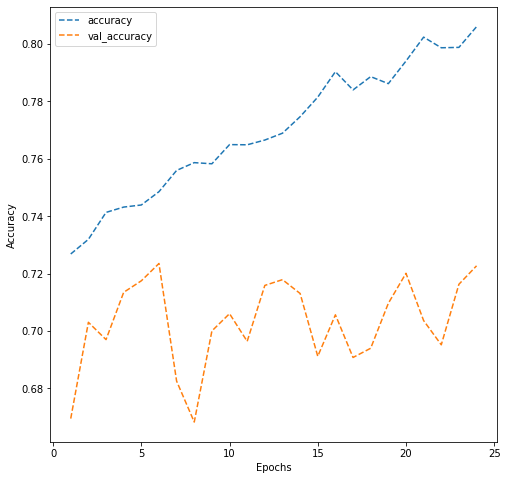

In [ ]:
dict_hist = new_history_2.history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

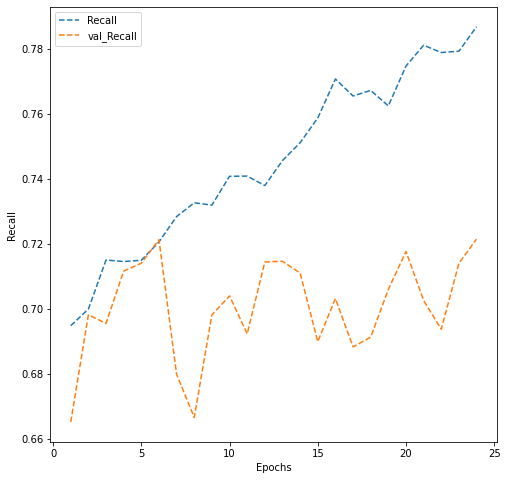

In [ ]:
plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['recall'], ls = '--', label = 'Recall')

plt.plot(list_ep, dict_hist['val_recall'], ls = '--', label = 'val_Recall')

plt.ylabel('Recall')

plt.xlabel('Epochs')

plt.legend()

plt.show()

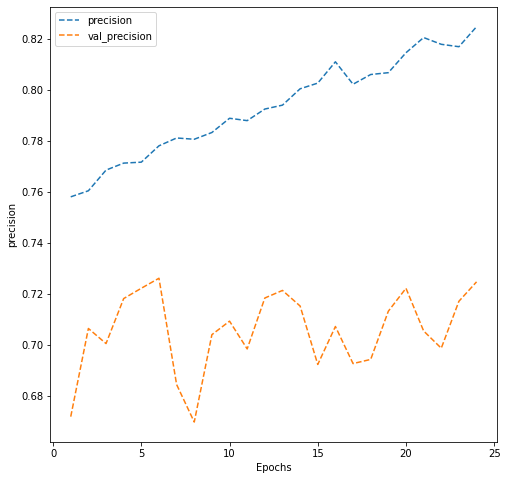

In [ ]:
plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['precision'], ls = '--', label = 'precision')

plt.plot(list_ep, dict_hist['val_precision'], ls = '--', label = 'val_precision')

plt.ylabel('precision')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
model1.evaluate(test_set)

Found 128 images belonging to 4 classes.
1/1 [==============================] - 0s 496ms/step - loss: 0.9982 - accuracy: 0.5078


[0.9981622099876404, 0.5078125]

### **Evaluating Second Model**: not better

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.72      0.88      0.79        32
           1       0.23      0.28      0.25        32
           2       0.17      0.12      0.14        32
           3       0.96      0.75      0.84        32

    accuracy                           0.51       128
   macro avg       0.52      0.51      0.51       128
weighted avg       0.52      0.51      0.51       128



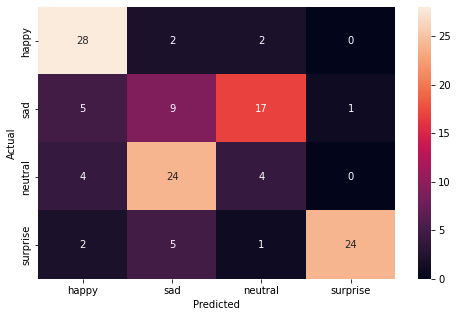

In [ ]:
test_images, test_labels = next(test_set)

pred = model1.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
metrics_score(y_true, pred)

For surprise: recall and F1 score improved.

For neutral: all metrics declined.

For sad: all metrics improved.

For happy: all metrics declined. 

The model appears to be continuing to underfit. I think it may be prudent to decrease dropout and further increase complexity:

Having kept some previous weights, we can see this model also overfits decently severely. This sets us up well to explore some techniques on how to further increase accuracy while also decreasing overfitting.

## **Hyper parameter tuning**

Lets build a baseline model on top of my pretrained conv layers

In [ ]:
from tensorflow.keras import backend

backend.clear_session()
def build_model_4():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dense(4, 
                activation="softmax"))
  #model4.summary()
  return model4
def build_and_train_model(optimizer):
    model = build_model_4()
    model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(train_set_augmented, epochs=10, use_multiprocessing=True,
                     validation_data=validation_set_augmented)

##Optimizer:

I'll use vanilla SGD as the baseline

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001)

In [ ]:
history_sgd = build_and_train_model(optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 128)       3328      
                                                                 
 max_pooling2d_6 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 512)       1

### Momentum

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [ ]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6969 - accuracy: 0.7302 - val_loss: 0.7229 - val_accuracy: 0.7179
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6581 - accuracy: 0.7357 - val_loss: 0.7134 - val_accuracy: 0.7231
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6521 - accuracy: 0.7448 - val_loss: 0.6989 - val_accuracy: 0.7241
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6418 - accuracy: 0.7470 - val_loss: 0.6975 - val_accuracy: 0.7269
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6459 - accuracy: 0.7428 - val_loss: 0.6943 - val_accuracy: 0.7296
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6493 - accuracy: 0.7423 - val_loss: 0.6856 - val_accuracy: 0.7314
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6453 - accuracy: 0.7459 - val_loss: 0.6884 - val_accuracy:

###Nesterov Accelerated Gradient


In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [ ]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6746 - accuracy: 0.7339 - val_loss: 0.7142 - val_accuracy: 0.7249
Epoch 2/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6426 - accuracy: 0.7511 - val_loss: 0.6892 - val_accuracy: 0.7314
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6329 - accuracy: 0.7488 - val_loss: 0.6944 - val_accuracy: 0.7298
Epoch 4/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6371 - accuracy: 0.7462 - val_loss: 0.6724 - val_accuracy: 0.7386
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6238 - accuracy: 0.7569 - val_loss: 0.7018 - val_accuracy: 0.7296
Epoch 6/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6246 - accuracy: 0.7567 - val_loss: 0.7013 - val_accuracy: 0.7330
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6241 - accuracy: 0.7521 - val_loss: 0.6830 - val_accuracy:

### AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

In [ ]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6611 - accuracy: 0.7490 - val_loss: 0.6796 - val_accuracy: 0.7428
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6119 - accuracy: 0.7643 - val_loss: 0.6700 - val_accuracy: 0.7366
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6068 - accuracy: 0.7621 - val_loss: 0.6645 - val_accuracy: 0.7394
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5975 - accuracy: 0.7648 - val_loss: 0.6667 - val_accuracy: 0.7424
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5965 - accuracy: 0.7640 - val_loss: 0.6680 - val_accuracy: 0.7442
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5895 - accuracy: 0.7676 - val_loss: 0.6537 - val_accuracy: 0.7517
Epoch 7/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5954 - accuracy: 0.7643 - val_loss: 0.6589 - val_accuracy:

### RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [ ]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 19s 37ms/step - loss: 0.7278 - accuracy: 0.7261 - val_loss: 0.7503 - val_accuracy: 0.7129
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7250 - accuracy: 0.7220 - val_loss: 0.7340 - val_accuracy: 0.7169
Epoch 3/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7286 - accuracy: 0.7210 - val_loss: 0.7794 - val_accuracy: 0.7002
Epoch 4/10
473/473 [==============================] - 17s 37ms/step - loss: 0.7348 - accuracy: 0.7189 - val_loss: 0.7877 - val_accuracy: 0.6699
Epoch 5/10
473/473 [==============================] - 18s 38ms/step - loss: 0.7442 - accuracy: 0.7137 - val_loss: 0.8480 - val_accuracy: 0.7000
Epoch 6/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7729 - accuracy: 0.7126 - val_loss: 0.9816 - val_accuracy: 0.7217
Epoch 7/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7624 - accuracy: 0.7079 - val_loss: 0.8889 - val_accuracy:

### Adam Optimizers

In [ ]:
optimizer = keras.optimizers.Adam()

In [ ]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7925 - accuracy: 0.6876 - val_loss: 0.6960 - val_accuracy: 0.7205
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7084 - accuracy: 0.7212 - val_loss: 0.7865 - val_accuracy: 0.6944
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6828 - accuracy: 0.7305 - val_loss: 0.6873 - val_accuracy: 0.7298
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6732 - accuracy: 0.7374 - val_loss: 0.7210 - val_accuracy: 0.7215
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6706 - accuracy: 0.7287 - val_loss: 0.6597 - val_accuracy: 0.7470
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6630 - accuracy: 0.7402 - val_loss: 0.7251 - val_accuracy: 0.7245
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6440 - accuracy: 0.7452 - val_loss: 0.6833 - val_accuracy:

#### Adamax

In [ ]:
optimizer = keras.optimizers.Adamax()

In [ ]:
history_adamax = build_and_train_model(optimizer) 

Epoch 1/10
473/473 [==============================] - 27s 37ms/step - loss: 0.4346 - accuracy: 0.8438 - val_loss: 0.8509 - val_accuracy: 0.7460
Epoch 2/10
473/473 [==============================] - 17s 37ms/step - loss: 0.3804 - accuracy: 0.8648 - val_loss: 0.8431 - val_accuracy: 0.7551
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.3499 - accuracy: 0.8740 - val_loss: 0.8526 - val_accuracy: 0.7416
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.3440 - accuracy: 0.8740 - val_loss: 0.8182 - val_accuracy: 0.7559
Epoch 5/10
473/473 [==============================] - 18s 37ms/step - loss: 0.3362 - accuracy: 0.8790 - val_loss: 0.7858 - val_accuracy: 0.7529
Epoch 6/10
473/473 [==============================] - 17s 37ms/step - loss: 0.3209 - accuracy: 0.8840 - val_loss: 0.8027 - val_accuracy: 0.7509
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.3217 - accuracy: 0.8829 - val_loss: 0.8227 - val_accuracy:

#### Nadam

In [ ]:
optimizer = keras.optimizers.Nadam()

In [ ]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 21s 39ms/step - loss: 0.6338 - accuracy: 0.7558 - val_loss: 0.7058 - val_accuracy: 0.7440
Epoch 2/10
473/473 [==============================] - 18s 38ms/step - loss: 0.6129 - accuracy: 0.7605 - val_loss: 0.7348 - val_accuracy: 0.7139
Epoch 3/10
473/473 [==============================] - 18s 38ms/step - loss: 0.6082 - accuracy: 0.7576 - val_loss: 0.6523 - val_accuracy: 0.7458
Epoch 4/10
473/473 [==============================] - 18s 38ms/step - loss: 0.6206 - accuracy: 0.7572 - val_loss: 0.6988 - val_accuracy: 0.7392
Epoch 5/10
473/473 [==============================] - 18s 39ms/step - loss: 0.5908 - accuracy: 0.7685 - val_loss: 0.6690 - val_accuracy: 0.7402
Epoch 6/10
473/473 [==============================] - 18s 39ms/step - loss: 0.6012 - accuracy: 0.7604 - val_loss: 0.6616 - val_accuracy: 0.7452
Epoch 7/10
473/473 [==============================] - 18s 38ms/step - loss: 0.5811 - accuracy: 0.7676 - val_loss: 0.6874 - val_accuracy:

#### AdamW

In [ ]:
%pip install -q -U tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

In [ ]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
473/473 [==============================] - 19s 38ms/step - loss: 0.6252 - accuracy: 0.7536 - val_loss: 0.6547 - val_accuracy: 0.7478
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5910 - accuracy: 0.7709 - val_loss: 0.7171 - val_accuracy: 0.7322
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5856 - accuracy: 0.7685 - val_loss: 0.6999 - val_accuracy: 0.7318
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5816 - accuracy: 0.7695 - val_loss: 0.6912 - val_accuracy: 0.7478
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5719 - accuracy: 0.7729 - val_loss: 0.7548 - val_accuracy: 0.7139
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5678 - accuracy: 0.7744 - val_loss: 0.6684 - val_accuracy: 0.7480
Epoch 7/10
473/473 [==============================] - 18s 37ms/step - loss: 0.5611 - accuracy: 0.7760 - val_loss: 0.6632 - val_accuracy:

### Evaluating:

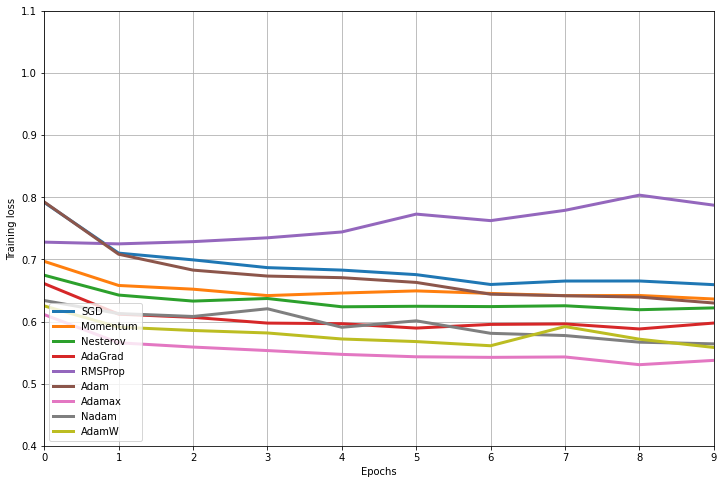

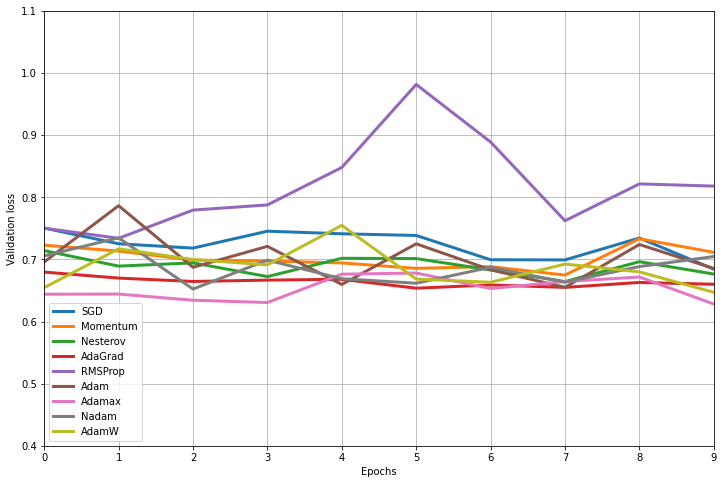

In [ ]:
# visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, 
                                  history_momentum, 
                                  history_nesterov,
                                  history_adagrad, 
                                  history_rmsprop, 
                                  history_adam,
                                  history_adamax, 
                                  history_nadam, 
                                  history_adamw),
                                  opt_names.split()):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", 
                "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 
              9, 
              0.4, 
              1.1])
    plt.show()

It looks like Adamax wins out on both training and validation sets.

## Learning Rate Scheduling


### Power scheduling

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, decay=1e-4)

In [ ]:
model = build_model_4()

model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
history_power_scheduling = history_exponential_scheduling = model.fit(train_set_augmented, 
                                           epochs=10, 
                                           use_multiprocessing=True,
                                           validation_data=validation_set_augmented
                                           )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.3875 - accuracy: 0.8613 - val_loss: 0.7241 - val_accuracy: 0.7533
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.3160 - accuracy: 0.8861 - val_loss: 0.7856 - val_accuracy: 0.7478
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.3002 - accuracy: 0.8899 - val_loss: 0.8381 - val_accuracy: 0.7647
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2780 - accuracy: 0.9030 - val_loss: 0.8734 - val_accuracy: 0.7482
Epoch 5/10
473/473 [==============================] - 18s 37ms/step - loss: 0.2705 - accuracy: 0.8991 - val_loss: 0.8357 - val_accuracy: 0.7583
Epoch 6/10
473/473 [==============================] - 17s 37ms/step - loss: 0.2522 - accuracy: 0.9068 - val_loss: 1.0241 - val_accuracy: 0.7521
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2436 - accuracy: 0.9123 - val_loss: 0.8824 - val_accuracy:

### Exponential scheduling

Much of the code in the following few sections is borrowed from: 

https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb

#### Batch-wise

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.001, s=20)

In [ ]:
model = build_model_4()

model.compile(loss="categorical_crossentropy", optimizer='adamax',
                metrics=["accuracy"])

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history_exponential_scheduling = model.fit(train_set_augmented, 
                                           epochs=10, 
                                           use_multiprocessing=True,
                                           validation_data=validation_set_augmented,
                                           callbacks=[lr_scheduler])

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.3419 - accuracy: 0.8789 - val_loss: 0.9378 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2643 - accuracy: 0.9069 - val_loss: 0.9421 - val_accuracy: 0.7505 - lr: 8.9125e-04
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2382 - accuracy: 0.9152 - val_loss: 0.8957 - val_accuracy: 0.7567 - lr: 7.9433e-04
Epoch 4/10
473/473 [==============================] - 17s 37ms/step - loss: 0.2205 - accuracy: 0.9185 - val_loss: 0.8821 - val_accuracy: 0.7563 - lr: 7.0795e-04
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2082 - accuracy: 0.9258 - val_loss: 0.9316 - val_accuracy: 0.7519 - lr: 6.3096e-04
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.1848 - accuracy: 0.9322 - val_loss: 0.9898 - val_accuracy: 0.7573 - lr: 5.6234e-04
Epoch 7/10
473/473 [==================

#### Iteration-wise

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [ ]:
lr0 = 0.001
model = build_model_4()
optimizer = keras.optimizers.Adamax(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
import math
n_epochs = 10
batch_size = 32
n_steps = n_epochs * math.ceil(15109 / batch_size)
exp_decay = ExponentialDecay(n_steps)
history_iteration_wise_exponential_scheduling = model.fit(train_set_augmented, 
                                                          epochs=n_epochs,
                                                          validation_data=validation_set_augmented, 
                                                          use_multiprocessing = True,
                                                          callbacks=[exp_decay])

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.2847 - accuracy: 0.9007 - val_loss: 1.0487 - val_accuracy: 0.7567 - lr: 7.9433e-04
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.2131 - accuracy: 0.9222 - val_loss: 0.9629 - val_accuracy: 0.7637 - lr: 6.3096e-04
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.1865 - accuracy: 0.9327 - val_loss: 1.1349 - val_accuracy: 0.7611 - lr: 5.0119e-04
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.1660 - accuracy: 0.9413 - val_loss: 0.9743 - val_accuracy: 0.7651 - lr: 3.9811e-04
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.1573 - accuracy: 0.9447 - val_loss: 1.0112 - val_accuracy: 0.7693 - lr: 3.1623e-04
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.1350 - accuracy: 0.9509 - val_loss: 1.0373 - val_accuracy: 0.7621 - lr: 2.5119e-04
Epoch 7/10
473/473 [==============

### Piecewise Constant Scheduling


In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 3:
        return 0.001
    elif epoch < 7:
        return 0.0005
    else:
        return 0.0001

In [ ]:
n_epochs = 10

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model_4()
optimizer = keras.optimizers.Adamax(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history_piecewise_constant_scheduling = model.fit(train_set_augmented, 
                                                  epochs=n_epochs,
                                                  validation_data=validation_set_augmented,
                                                  callbacks=[lr_scheduler])

Epoch 1/10
473/473 [==============================] - 19s 39ms/step - loss: 0.3068 - accuracy: 0.8873 - val_loss: 1.0572 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 2/10
473/473 [==============================] - 18s 38ms/step - loss: 0.2404 - accuracy: 0.9144 - val_loss: 1.0715 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 3/10
473/473 [==============================] - 18s 39ms/step - loss: 0.2114 - accuracy: 0.9253 - val_loss: 0.9565 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 4/10
473/473 [==============================] - 18s 39ms/step - loss: 0.1754 - accuracy: 0.9361 - val_loss: 0.9329 - val_accuracy: 0.7575 - lr: 5.0000e-04
Epoch 5/10
473/473 [==============================] - 19s 39ms/step - loss: 0.1588 - accuracy: 0.9429 - val_loss: 1.0344 - val_accuracy: 0.7645 - lr: 5.0000e-04
Epoch 6/10
473/473 [==============================] - 18s 38ms/step - loss: 0.1561 - accuracy: 0.9460 - val_loss: 1.0291 - val_accuracy: 0.7593 - lr: 5.0000e-04
Epoch 7/10
473/473 [==========================

### Performance Scheduling

In [ ]:
model = build_model_4()
optimizer = keras.optimizers.Adamax(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
history_performance_scheduling = model.fit(train_set_augmented, 
                                           epochs=10,
                                           validation_data=validation_set_augmented,
                                           callbacks=[lr_scheduler])

Epoch 1/10
473/473 [==============================] - 19s 38ms/step - loss: 0.2887 - accuracy: 0.8979 - val_loss: 1.0817 - val_accuracy: 0.7376 - lr: 0.0010
Epoch 2/10
473/473 [==============================] - 18s 38ms/step - loss: 0.2125 - accuracy: 0.9234 - val_loss: 1.0433 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 3/10
473/473 [==============================] - 18s 38ms/step - loss: 0.2081 - accuracy: 0.9255 - val_loss: 0.8836 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 4/10
473/473 [==============================] - 18s 38ms/step - loss: 0.1857 - accuracy: 0.9321 - val_loss: 0.9349 - val_accuracy: 0.7466 - lr: 0.0010
Epoch 5/10
473/473 [==============================] - 18s 38ms/step - loss: 0.1873 - accuracy: 0.9350 - val_loss: 0.9952 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 6/10
473/473 [==============================] - 18s 39ms/step - loss: 0.1508 - accuracy: 0.9443 - val_loss: 1.0562 - val_accuracy: 0.7611 - lr: 5.0000e-04
Epoch 7/10
473/473 [==============================] - 

### 1Cycle Scheduling

In [9]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

In [10]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-5, max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, 
                        y, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        callbacks=[
                                  exp_lr
                                  ]
                        )
    K.set_value(model.optimizer.learning_rate, 
                init_lr
                )
    model.set_weights(init_weights
                      )
    return exp_lr.rates, exp_lr.losses

In [11]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, 
             losses, 
             "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), 
               min(rates), 
               max(rates), 
               color="k"
               )
    plt.axis([min(rates), 
              max(rates), 
              0, 
              max_loss]
             )
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [ ]:
model = build_model_4()
model.compile(loss="categorical_crossentropy",
              optimizer='adamax',
              metrics=["accuracy"])

Epoch 1/5
1/1 [==============================] - 0s 30ms/step - loss: 1.4942 - accuracy: 0.3750
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.4835 - accuracy: 0.3750
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 1.2847 - accuracy: 0.4062
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 0.5899 - accuracy: 0.9688
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 0.8460 - accuracy: 0.9375


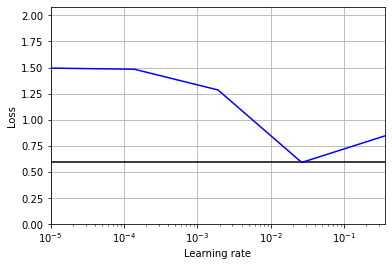

In [ ]:
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   max_rate=5
                                   )
plot_lr_vs_loss(rates, losses) # This takes some tuning. I ran this block several times to find the optimal value

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, 
                                   self.half_iteration, 
                                   self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 
                                   2 * self.half_iteration,
                                   self.max_lr, 
                                   self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, 
                                   self.iterations,
                                   self.start_lr, 
                                   self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [ ]:
model = build_model_4()
model.compile(loss="categorical_crossentropy",
              optimizer='adamax',
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.02) #.02 found from minimizing the plot_lr_vs_loss graph
history_1cycle = model.fit(train_set_augmented, 
                           epochs=n_epochs, 
                           batch_size=batch_size,
                           validation_data=validation_set_augmented,
                           callbacks=[onecycle])

Epoch 1/10
473/473 [==============================] - 19s 39ms/step - loss: 0.6100 - accuracy: 0.7781 - val_loss: 0.8695 - val_accuracy: 0.6755
Epoch 2/10
473/473 [==============================] - 19s 39ms/step - loss: 0.7259 - accuracy: 0.7187 - val_loss: 0.7699 - val_accuracy: 0.7123
Epoch 3/10
473/473 [==============================] - 18s 39ms/step - loss: 0.8130 - accuracy: 0.6798 - val_loss: 0.8356 - val_accuracy: 0.6373
Epoch 4/10
473/473 [==============================] - 19s 39ms/step - loss: 0.8683 - accuracy: 0.6423 - val_loss: 0.8443 - val_accuracy: 0.6639
Epoch 5/10
473/473 [==============================] - 18s 38ms/step - loss: 0.9297 - accuracy: 0.6060 - val_loss: 0.8957 - val_accuracy: 0.6454
Epoch 6/10
473/473 [==============================] - 18s 39ms/step - loss: 0.8798 - accuracy: 0.6433 - val_loss: 0.7977 - val_accuracy: 0.6936
Epoch 7/10
473/473 [==============================] - 18s 39ms/step - loss: 0.8106 - accuracy: 0.6670 - val_loss: 0.8399 - val_accuracy:

### Evaluating:

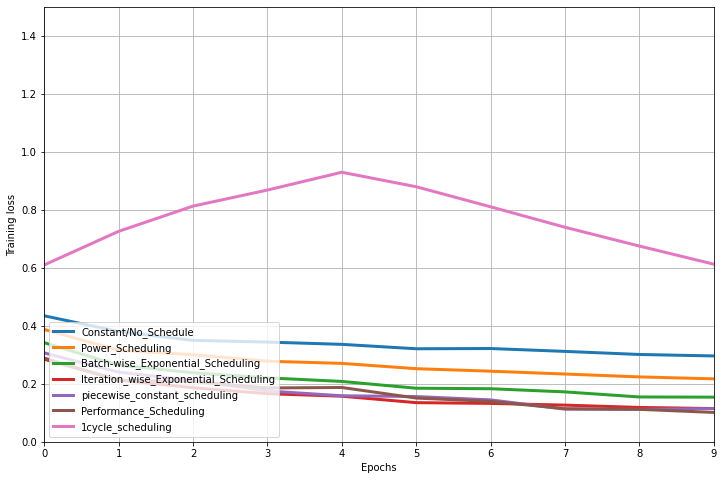

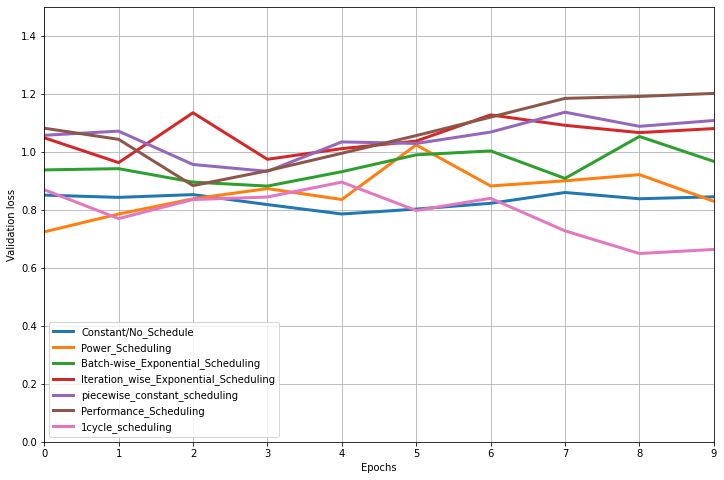

In [ ]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "Constant/No_Schedule Power_Scheduling Batch-wise_Exponential_Scheduling Iteration_wise_Exponential_Scheduling piecewise_constant_scheduling Performance_Scheduling 1cycle_scheduling"
    for history, opt_name in zip((history_adamax, history_power_scheduling, history_exponential_scheduling, history_iteration_wise_exponential_scheduling,
                                  history_piecewise_constant_scheduling, history_performance_scheduling, history_1cycle),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 9, 0, 1.5])
    plt.show()

It looks like 1-cycle scheduling performs best to avoid overfitting: It performs about the same on the validation and test sets. It is also the only schedule (including no-schedule) to decrease validation loss on our overfitting model.

## Regularization

Regularization is another technique to reduce overfitting.

In [ ]:
def build_model_5():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal", 
                  kernel_regularizer=keras.regularizers.l2(0.01)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l2(0.01)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l2(0.01)))
  model4.add(Dense(4, 
                activation="softmax"))
  #model4.summary()
  return model4
def build_and_train_model(optimizer):
    model = build_model_5()
    model.compile(loss="categorical_crossentropy", 
                  optimizer='adamax',
                  metrics=["accuracy"])
    return model.fit(train_set_augmented, 
                     epochs=10, 
                     use_multiprocessing=True,
                     validation_data=validation_set_augmented, 
                     callbacks=[onecycle])

In [ ]:
history_l2 = build_and_train_model('adamax')

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 661289428984667308032.0000 - accuracy: 0.2426 - val_loss: 18337275077567056969728.0000 - val_accuracy: 0.3667
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 407661044495748118945111998464.0000 - accuracy: 0.2632 - val_loss: 4698491709089530805782021406720.0000 - val_accuracy: 0.3667
Epoch 3/10
473/473 [==============================] - 18s 37ms/step - loss: 17361487605077737094562217881239552.0000 - accuracy: 0.2632 - val_loss: inf - val_accuracy: 0.3667
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: inf - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 6/10
473/473 [==============================] - 18s 37ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 7/10
473/473 [==

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
def build_model_5():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal", 
                  kernel_regularizer=keras.regularizers.l1(0.1)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(0.1)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1(0.1)))
  model4.add(Dense(4, 
                activation="softmax"))
  #model4.summary()
  return model4
model = build_model_5()
model.compile(loss="categorical_crossentropy", optimizer='adamax',
              metrics=["accuracy"])
history_l1 = model.fit(train_set_augmented, 
                       epochs=1, use_multiprocessing=True,
                       validation_data=validation_set_augmented, 
                       callbacks=[onecycle])

473/473 [==============================] - 18s 36ms/step - loss: nan - accuracy: 0.2629 - val_loss: nan - val_accuracy: 0.3667


In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
def build_model_5():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal", 
                  kernel_regularizer=keras.regularizers.l1_l2(0.1, 0.01)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1_l2(0.1, 0.01)))
  model4.add(Dense(100, 
                  activation="relu",
                  kernel_initializer="he_normal",
                  kernel_regularizer=keras.regularizers.l1_l2(0.1, 0.01)))
  model4.add(Dense(4, 
                activation="softmax"))
  #model4.summary()
  return model4
model = build_model_5()
model.compile(loss="categorical_crossentropy", 
              optimizer='adamax',
              metrics=["accuracy"])
history_l1_l2 = model.fit(train_set_augmented, 
                          epochs=10, 
                          use_multiprocessing=True,
                          validation_data=validation_set_augmented, 
                          callbacks=[onecycle])

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: nan - accuracy: 0.2656 - val_loss: nan - val_accuracy: 0.3667
Epoch 2/10
473/473 [==============================] - 17s 37ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: nan - accuracy: 0.2632 - val_loss: nan - val_accuracy: 0.3667
Epoch 8/10
473/473 [==============

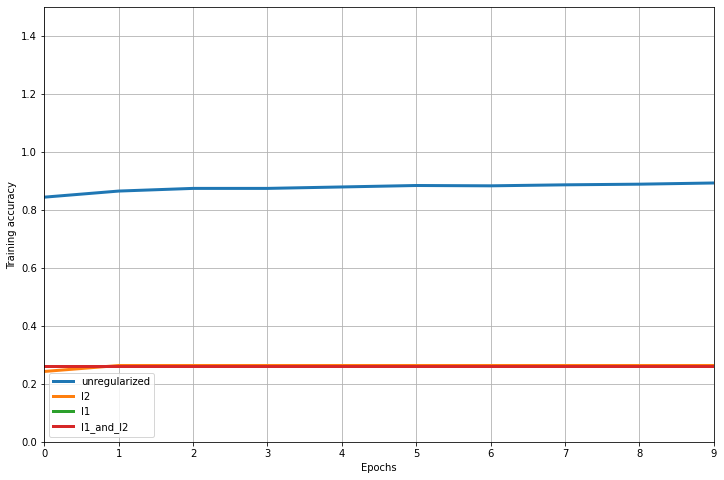

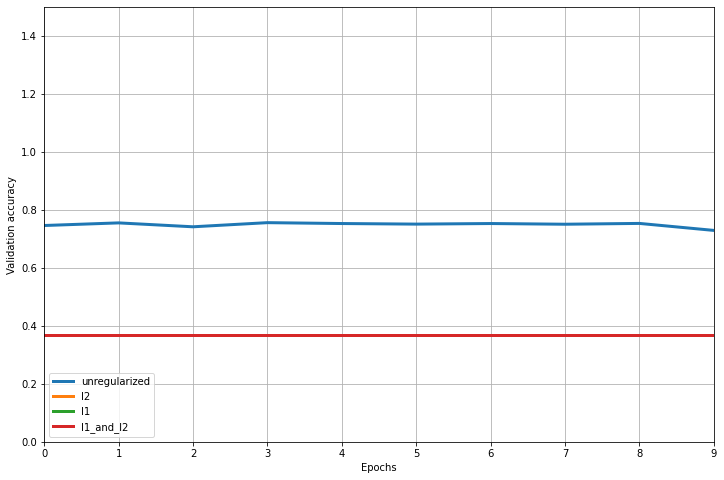

In [ ]:
for acc in ("accuracy", "val_accuracy"):
    plt.figure(figsize=(12, 8))
    opt_names = "unregularized l2 l1 l1_and_l2 piecewise_constant_scheduling Performance_Scheduling 1cycle_scheduling"
    for history, opt_name in zip((history_adamax, 
                                  history_l2, 
                                  history_l1, 
                                  history_l1_l2),
                                  opt_names.split()):
        plt.plot(history.history[acc], 
                 label=f"{opt_name}", 
                 linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"accuracy": "Training accuracy", "val_accuracy": "Validation accuracy"}[acc])
    plt.legend(loc="lower left")
    plt.axis([0, 9, 0, 1.5])
    plt.show()

Clearly not going to work. This took some effort to verify that it really was indeed not goint to work *this badly.* This matches up with some earlier experiments I ran in trying out the selu activation function and lecun-normal initialization to try to reduce overfitting (omitted from this nb). I suspect having scaled the images upon import probably helps and negates the need for further regular/normalization measures.

## Dropout

Lets first try 20% dropout. I had some luck with that in the previous notebook.

Epoch 1/5
1/1 [==============================] - 1s 824ms/step - loss: 1.4454 - accuracy: 0.2812
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 1.4775 - accuracy: 0.1562
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 1.3098 - accuracy: 0.3438
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 0.7510 - accuracy: 0.7812
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 8.1974 - accuracy: 0.4688


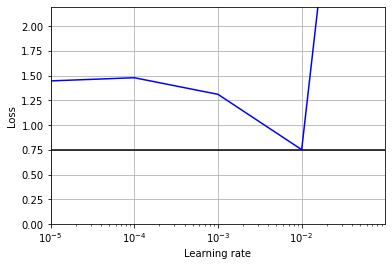

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
def build_model_6():
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dropout(rate=0.2)),
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal")
                  )
  model4.add(Dropout(rate=0.2))
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal")
                  )
  model4.add(Dropout(rate=0.2))
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dropout(rate=0.2))
  model4.add(Dense(4,
                   activation="softmax"))
  #model4.summary()
  return model4
model = build_model_6()
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, train_images, train_labels, epochs=5,
                                   batch_size=batch_size, max_rate=1)
plot_lr_vs_loss(rates, losses)


In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_20 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                                )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.5457 - accuracy: 0.8107 - val_loss: 0.7744 - val_accuracy: 0.7193
Epoch 2/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6031 - accuracy: 0.7878 - val_loss: 0.7172 - val_accuracy: 0.7205
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6864 - accuracy: 0.7408 - val_loss: 0.7297 - val_accuracy: 0.7201
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7633 - accuracy: 0.7099 - val_loss: 0.7944 - val_accuracy: 0.7173
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.8293 - accuracy: 0.6727 - val_loss: 0.8146 - val_accuracy: 0.6671
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7794 - accuracy: 0.6951 - val_loss: 0.8229 - val_accuracy: 0.6940
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7207 - accuracy: 0.7181 - val_loss: 0.6868 - val_accuracy:

Trying the 40-50% region because thats standard practice for CNNs.

Epoch 1/5
1/1 [==============================] - 1s 814ms/step - loss: 1.9205 - accuracy: 0.1875
Epoch 2/5
1/1 [==============================] - 0s 31ms/step - loss: 1.9407 - accuracy: 0.1250
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.6301 - accuracy: 0.2500
Epoch 4/5
1/1 [==============================] - 0s 30ms/step - loss: 1.2467 - accuracy: 0.4062
Epoch 5/5
1/1 [==============================] - 0s 28ms/step - loss: 2.2657 - accuracy: 0.3750


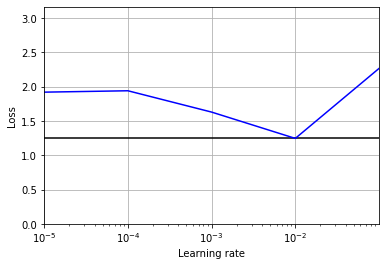

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
def build_model_6(dropout = 0):
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dropout(rate=dropout)),
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dropout(rate=dropout)),
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dropout(rate=dropout)),
  model4.add(Dense(128, 
                  activation="relu",
                  kernel_initializer="he_normal"))
  model4.add(Dropout(rate=dropout)),
  model4.add(Dense(4, 
                activation="softmax"))
  #model4.summary()
  return model4
model = build_model_6(dropout = 0.4)
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"]
              )
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   max_rate=1
                                   )
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_40 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7308 - accuracy: 0.7374 - val_loss: 0.7943 - val_accuracy: 0.7233
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7246 - accuracy: 0.7438 - val_loss: 0.8150 - val_accuracy: 0.7028
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7856 - accuracy: 0.7069 - val_loss: 0.7447 - val_accuracy: 0.7145
Epoch 4/10
473/473 [==============================] - 17s 37ms/step - loss: 0.8326 - accuracy: 0.6815 - val_loss: 0.8291 - val_accuracy: 0.6747
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.8729 - accuracy: 0.6511 - val_loss: 0.8293 - val_accuracy: 0.6572
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.8455 - accuracy: 0.6691 - val_loss: 0.7555 - val_accuracy: 0.6952
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7791 - accuracy: 0.6957 - val_loss: 0.7279 - val_accuracy:

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
model = build_model_6(dropout = 0.45) # 45% dropout
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)


Epoch 1/6
1/1 [==============================] - 0s 32ms/step - loss: 2.0244 - accuracy: 0.1250
Epoch 2/6
1/1 [==============================] - 0s 29ms/step - loss: 1.2658 - accuracy: 0.3125
Epoch 3/6
1/1 [==============================] - 0s 30ms/step - loss: 1.0427 - accuracy: 0.6562
Epoch 4/6
1/1 [==============================] - 0s 29ms/step - loss: 1.1041 - accuracy: 0.5312
Epoch 5/6
1/1 [==============================] - 0s 29ms/step - loss: 1.2256 - accuracy: 0.4062
Epoch 6/6
1/1 [==============================] - 0s 25ms/step - loss: 2.4796 - accuracy: 0.3750


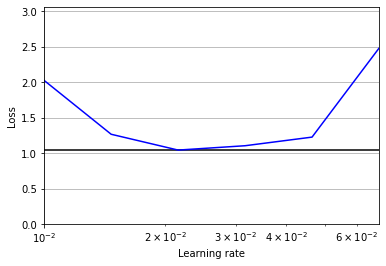

In [ ]:
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=6,
                                   batch_size=batch_size, 
                                   min_rate = 1e-2, 
                                   max_rate=.1)
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.025)

history_dropout_45 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.8785 - accuracy: 0.6642 - val_loss: 0.7863 - val_accuracy: 0.7002
Epoch 2/10
473/473 [==============================] - 17s 37ms/step - loss: 0.8895 - accuracy: 0.6588 - val_loss: 0.8597 - val_accuracy: 0.6763
Epoch 3/10
473/473 [==============================] - 18s 37ms/step - loss: 0.9587 - accuracy: 0.6124 - val_loss: 0.8664 - val_accuracy: 0.6536
Epoch 4/10
473/473 [==============================] - 18s 37ms/step - loss: 1.0243 - accuracy: 0.5749 - val_loss: 1.0214 - val_accuracy: 0.5624
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 1.0975 - accuracy: 0.5187 - val_loss: 1.0750 - val_accuracy: 0.5120
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 1.0919 - accuracy: 0.5127 - val_loss: 0.9297 - val_accuracy: 0.6064
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 1.0217 - accuracy: 0.5485 - val_loss: 0.9662 - val_accuracy:

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
model = build_model_6(dropout = 0.5) #50% dropout
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)

Epoch 1/5
1/1 [==============================] - 0s 33ms/step - loss: 2.5968 - accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 1.5614 - accuracy: 0.2812
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.0689 - accuracy: 0.4688
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 1.3351 - accuracy: 0.4062
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 2.2527 - accuracy: 0.2500


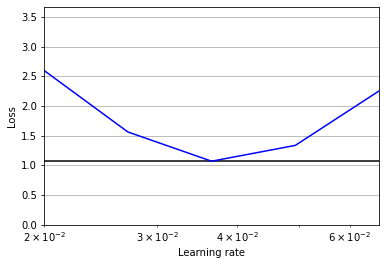

In [ ]:
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 2e-2, 
                                   max_rate=9e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.035)

history_dropout_50 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 1.0160 - accuracy: 0.5842 - val_loss: 0.9545 - val_accuracy: 0.6188
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 1.0113 - accuracy: 0.5834 - val_loss: 0.9232 - val_accuracy: 0.6251
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 1.1268 - accuracy: 0.5011 - val_loss: 1.0510 - val_accuracy: 0.5164
Epoch 4/10
473/473 [==============================] - 18s 37ms/step - loss: 1.2411 - accuracy: 0.4170 - val_loss: 1.3661 - val_accuracy: 0.2375
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 1.3495 - accuracy: 0.3092 - val_loss: 1.3652 - val_accuracy: 0.3667
Epoch 6/10
473/473 [==============================] - 18s 37ms/step - loss: 1.3831 - accuracy: 0.2628 - val_loss: 1.3697 - val_accuracy: 0.2289
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 1.3825 - accuracy: 0.2585 - val_loss: 1.3709 - val_accuracy:

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
model = build_model_6(dropout = 0.25) #25% dropout
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)

Epoch 1/5
1/1 [==============================] - 1s 805ms/step - loss: 1.6798 - accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.0814 - accuracy: 0.4375
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 0.9361 - accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 0s 30ms/step - loss: 9.0886 - accuracy: 0.3750
Epoch 5/5
1/1 [==============================] - 0s 28ms/step - loss: 286.8265 - accuracy: 0.2500


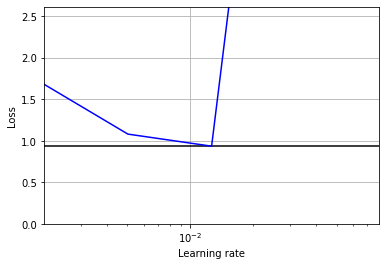

In [ ]:
model = build_model_6(dropout = 0.25)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 2e-3, 
                                   max_rate=2e-1)
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_25 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.5612 - accuracy: 0.8118 - val_loss: 0.9169 - val_accuracy: 0.7235
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5814 - accuracy: 0.7974 - val_loss: 0.7292 - val_accuracy: 0.7288
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6488 - accuracy: 0.7644 - val_loss: 0.7546 - val_accuracy: 0.7237
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6969 - accuracy: 0.7394 - val_loss: 0.7604 - val_accuracy: 0.6998
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7687 - accuracy: 0.7035 - val_loss: 0.7353 - val_accuracy: 0.7089
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7175 - accuracy: 0.7215 - val_loss: 0.7009 - val_accuracy: 0.7350
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7077 - accuracy: 0.7298 - val_loss: 0.7040 - val_accuracy:

In [ ]:
backend.clear_session()
model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")


Epoch 1/5
1/1 [==============================] - 1s 766ms/step - loss: 1.3673 - accuracy: 0.3438
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 2.0036 - accuracy: 0.4062
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.3519 - accuracy: 0.4375
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 1.4929 - accuracy: 0.3438
Epoch 5/5
1/1 [==============================] - 0s 30ms/step - loss: 1.8248 - accuracy: 0.2500


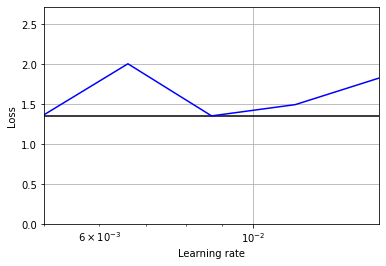

In [ ]:
model = build_model_6(dropout = 0.15)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 5e-3, 
                                   max_rate=2e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.009)

history_dropout_21 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.5393 - accuracy: 0.8178 - val_loss: 0.7728 - val_accuracy: 0.7036
Epoch 2/10
473/473 [==============================] - 18s 37ms/step - loss: 0.6068 - accuracy: 0.7796 - val_loss: 0.7944 - val_accuracy: 0.7093
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.6661 - accuracy: 0.7471 - val_loss: 0.7545 - val_accuracy: 0.7243
Epoch 4/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7375 - accuracy: 0.7148 - val_loss: 0.7503 - val_accuracy: 0.7067
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.7798 - accuracy: 0.7010 - val_loss: 0.7822 - val_accuracy: 0.6962
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7455 - accuracy: 0.7139 - val_loss: 0.7487 - val_accuracy: 0.6996
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6877 - accuracy: 0.7333 - val_loss: 0.7238 - val_accuracy:

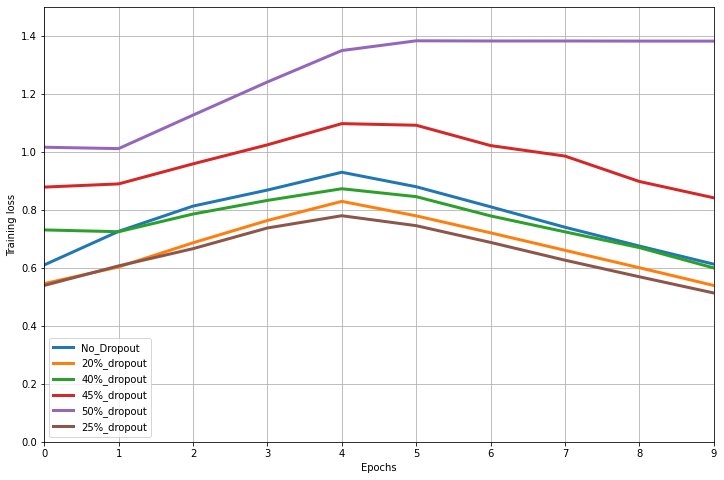

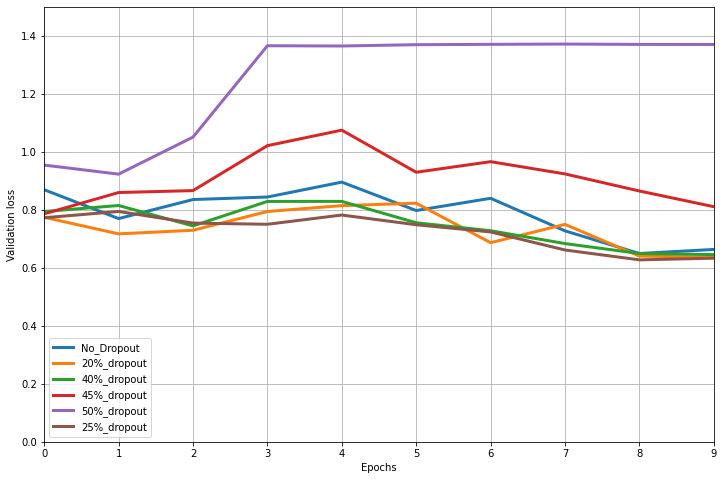

In [ ]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "No_Dropout 20%_dropout 40%_dropout 45%_dropout 50%_dropout 25%_dropout 15%_dropout"
    for history, opt_name in zip((history_1cycle, 
                                  history_dropout_20, 
                                  history_dropout_40, 
                                  history_dropout_45,
                                  history_dropout_50, 
                                  history_dropout_21),
                                  opt_names.split()
                                  ):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 
              9, 
              0, 
              1.5
              ]
             )
    plt.show()

Overall, it looks like 25% dropout is the way to go as it minimizes both the training and the validation loss. Again, I tried out the 40-50% range and the 15-25% range as I'd had luck on these data with the latter range but I read that 40-50 can work well in CNNs.

Lets train this setup and then evaluate it on the test data!

## Training a third model

### Determining ANN architecture.

We're going to have some dense layers sit on top of the convolutional layers. Lets test some combinations out.

In [ ]:
import keras
from keras import backend
def build_model(dropout = 0.25, n_dense = 1, n_neurons = 64, activation = 'relu', initializer = "he_normal"):
  backend.clear_session()
  model2 = keras.models.load_model("/content/drive/MyDrive/model2.h5")
  model4 = Sequential()
  for i in range(0,11):
    model4.add(model2.layers[i])
    model4.layers[i].set_weights(model2.layers[i].get_weights())
  model4.add(Flatten())
  model4.add(Dropout(rate=dropout))
  for i in range(0, n_dense):
    model4.add(Dense(n_neurons, 
                    activation=activation,
                    kernel_initializer=initializer)
                    )
    model4.add(Dropout(rate=dropout))
  model4.add(Dense(4,
                   activation="softmax")
                   )
  #model4.summary()
  return model4

Epoch 1/5
1/1 [==============================] - 1s 651ms/step - loss: 1.5062 - accuracy: 0.2188
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 0.4914 - accuracy: 0.9688
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.0839 - accuracy: 1.0000
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 1.6232 - accuracy: 0.9375
Epoch 5/5
1/1 [==============================] - 0s 28ms/step - loss: 2.8626 - accuracy: 0.8438


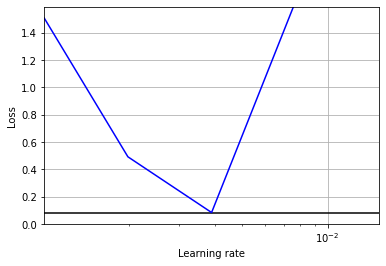

In [ ]:
import math
model = build_model()
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 1e-3, 
                                   max_rate=3e-2
                                   )
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)

history_dropout_nn64_nd1 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                                )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.4407 - accuracy: 0.8484 - val_loss: 0.7860 - val_accuracy: 0.7406
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.4178 - accuracy: 0.8508 - val_loss: 0.8225 - val_accuracy: 0.7364
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.4825 - accuracy: 0.8290 - val_loss: 0.7377 - val_accuracy: 0.7290
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5303 - accuracy: 0.8051 - val_loss: 0.7263 - val_accuracy: 0.7306
Epoch 5/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5605 - accuracy: 0.7887 - val_loss: 0.7126 - val_accuracy: 0.7338
Epoch 6/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5437 - accuracy: 0.7945 - val_loss: 0.7127 - val_accuracy: 0.7356
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.4959 - accuracy: 0.8159 - val_loss: 0.7918 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 750ms/step - loss: 1.7519 - accuracy: 0.2812
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 0.9829 - accuracy: 0.6250
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 0.6729 - accuracy: 0.7812
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 0.2798 - accuracy: 0.9062
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 0.7153 - accuracy: 0.8438


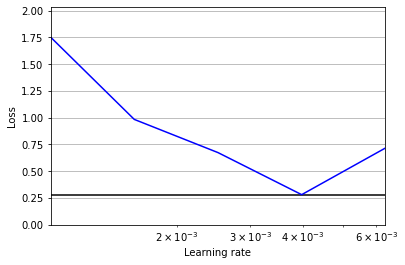

In [ ]:
model = build_model(dropout = 0.25, n_dense = 2, n_neurons = 64, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 1e-3, 
                                   max_rate=1e-2
                                   )
plot_lr_vs_loss(rates, losses)

In [ ]:
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)

history_dropout_nn64_nd2 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.4926 - accuracy: 0.8374 - val_loss: 0.8499 - val_accuracy: 0.7408
Epoch 2/10
473/473 [==============================] - 17s 37ms/step - loss: 0.4765 - accuracy: 0.8376 - val_loss: 0.7497 - val_accuracy: 0.7360
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5286 - accuracy: 0.8173 - val_loss: 0.7809 - val_accuracy: 0.7406
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5760 - accuracy: 0.7907 - val_loss: 0.7411 - val_accuracy: 0.7320
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6132 - accuracy: 0.7723 - val_loss: 0.7717 - val_accuracy: 0.7245
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5857 - accuracy: 0.7821 - val_loss: 0.6780 - val_accuracy: 0.7420
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5233 - accuracy: 0.8084 - val_loss: 0.7111 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 763ms/step - loss: 1.6183 - accuracy: 0.1562
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 0.8551 - accuracy: 0.7500
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.4336 - accuracy: 0.9375
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 0.0379 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 4.4698 - accuracy: 0.7812


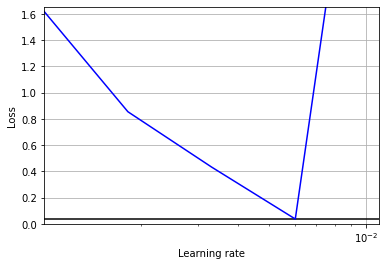

In [ ]:
model = build_model(dropout = 0.25, n_dense = 2, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 1e-3, 
                                   max_rate=2e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, n_dense = 2, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.006)

history_dropout_nn128_nd2 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.4817 - accuracy: 0.8396 - val_loss: 0.7629 - val_accuracy: 0.7509
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5181 - accuracy: 0.8161 - val_loss: 0.7411 - val_accuracy: 0.7320
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5832 - accuracy: 0.7877 - val_loss: 0.7386 - val_accuracy: 0.7095
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6407 - accuracy: 0.7622 - val_loss: 0.7240 - val_accuracy: 0.7207
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6912 - accuracy: 0.7379 - val_loss: 0.6883 - val_accuracy: 0.7279
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6464 - accuracy: 0.7494 - val_loss: 0.7052 - val_accuracy: 0.7330
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5962 - accuracy: 0.7746 - val_loss: 0.6907 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 833ms/step - loss: 1.4694 - accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 0.9791 - accuracy: 0.5938
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.7473 - accuracy: 0.7812
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 15.4869 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 27ms/step - loss: 33.5901 - accuracy: 0.3750


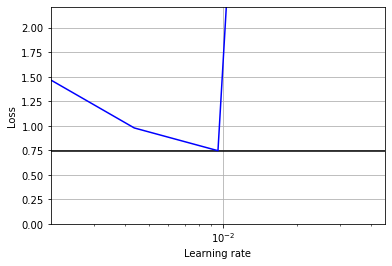

In [ ]:
model = build_model(dropout = 0.25, n_dense = 3, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 2e-3, 
                                   max_rate=1e-1)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 3, 
                    n_neurons = 128, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_nn128_nd3 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.5968 - accuracy: 0.7965 - val_loss: 0.7873 - val_accuracy: 0.7338
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6531 - accuracy: 0.7666 - val_loss: 0.8719 - val_accuracy: 0.6719
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.7259 - accuracy: 0.7270 - val_loss: 0.8799 - val_accuracy: 0.6659
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7864 - accuracy: 0.6945 - val_loss: 0.7738 - val_accuracy: 0.6948
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.8170 - accuracy: 0.6787 - val_loss: 0.8195 - val_accuracy: 0.6835
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.7985 - accuracy: 0.6887 - val_loss: 0.7997 - val_accuracy: 0.6727
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7336 - accuracy: 0.7132 - val_loss: 0.7670 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 1.4721 - accuracy: 0.3125
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 0.5137 - accuracy: 0.9375
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.0570 - accuracy: 0.9688
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 0.4214 - accuracy: 0.9375


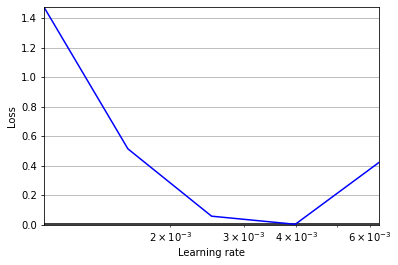

In [ ]:
model = build_model(dropout = 0.25, n_dense = 2, n_neurons = 256, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 1e-3, 
                                   max_rate=1e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 2, 
                    n_neurons = 256, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)

history_dropout_nn256_nd2 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.4264 - accuracy: 0.8550 - val_loss: 0.8348 - val_accuracy: 0.7322
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.4437 - accuracy: 0.8455 - val_loss: 0.7503 - val_accuracy: 0.7400
Epoch 3/10
473/473 [==============================] - 17s 35ms/step - loss: 0.4925 - accuracy: 0.8217 - val_loss: 0.7374 - val_accuracy: 0.7271
Epoch 4/10
473/473 [==============================] - 17s 35ms/step - loss: 0.5364 - accuracy: 0.7999 - val_loss: 0.6805 - val_accuracy: 0.7406
Epoch 5/10
473/473 [==============================] - 17s 35ms/step - loss: 0.5757 - accuracy: 0.7885 - val_loss: 0.7684 - val_accuracy: 0.7193
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.5573 - accuracy: 0.7944 - val_loss: 0.6843 - val_accuracy: 0.7440
Epoch 7/10
473/473 [==============================] - 17s 35ms/step - loss: 0.4938 - accuracy: 0.8200 - val_loss: 0.6842 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 816ms/step - loss: 1.5537 - accuracy: 0.1250
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 1.0303 - accuracy: 0.5312
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.5612 - accuracy: 0.7500
Epoch 4/5
1/1 [==============================] - 0s 28ms/step - loss: 0.3801 - accuracy: 0.9062
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 2.2790 - accuracy: 0.8750


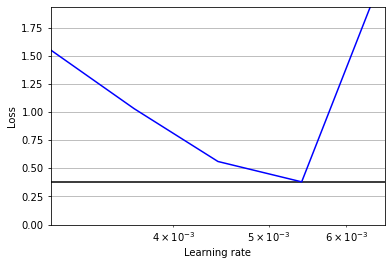

In [ ]:
model = build_model(dropout = 0.25, n_dense = 3, n_neurons = 256, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 3e-3, 
                                   max_rate=8e-3)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 3, 
                    n_neurons = 256, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.005)

history_dropout_nn256_nd3 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.4767 - accuracy: 0.8394 - val_loss: 0.9469 - val_accuracy: 0.7376
Epoch 2/10
473/473 [==============================] - 18s 37ms/step - loss: 0.4922 - accuracy: 0.8275 - val_loss: 0.7205 - val_accuracy: 0.7269
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5543 - accuracy: 0.7983 - val_loss: 0.7268 - val_accuracy: 0.7344
Epoch 4/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6044 - accuracy: 0.7794 - val_loss: 0.7494 - val_accuracy: 0.7185
Epoch 5/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6515 - accuracy: 0.7564 - val_loss: 0.7720 - val_accuracy: 0.7219
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6205 - accuracy: 0.7681 - val_loss: 0.7076 - val_accuracy: 0.7235
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5676 - accuracy: 0.7846 - val_loss: 0.7004 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 897ms/step - loss: 1.6041 - accuracy: 0.3438
Epoch 2/5
1/1 [==============================] - 0s 29ms/step - loss: 2.9487 - accuracy: 0.4062
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 2.1130 - accuracy: 0.3125
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 1.3583 - accuracy: 0.3750
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 4.6165 - accuracy: 0.3750


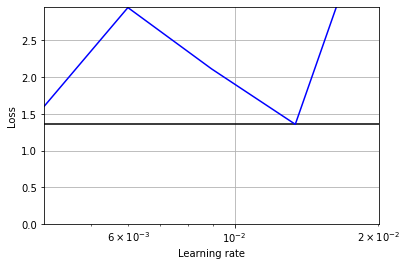

In [ ]:
model = build_model(dropout = 0.25, n_dense = 4, n_neurons = 256, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 4e-3, 
                                   max_rate=3e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 4, 
                    n_neurons = 256, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_nn256_nd4 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.6128 - accuracy: 0.7889 - val_loss: 0.8181 - val_accuracy: 0.7296
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6533 - accuracy: 0.7604 - val_loss: 0.8677 - val_accuracy: 0.6562
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7354 - accuracy: 0.7251 - val_loss: 0.7586 - val_accuracy: 0.7093
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7800 - accuracy: 0.7018 - val_loss: 0.9361 - val_accuracy: 0.5996
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.8600 - accuracy: 0.6642 - val_loss: 0.9227 - val_accuracy: 0.6339
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.8029 - accuracy: 0.6854 - val_loss: 0.7479 - val_accuracy: 0.7101
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7440 - accuracy: 0.7110 - val_loss: 0.7439 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 955ms/step - loss: 1.5939 - accuracy: 0.1875
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 11.1977 - accuracy: 0.3438
Epoch 3/5
1/1 [==============================] - 0s 30ms/step - loss: 1.2349 - accuracy: 0.3750
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 2.3609 - accuracy: 0.1875
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 2.4569 - accuracy: 0.2500


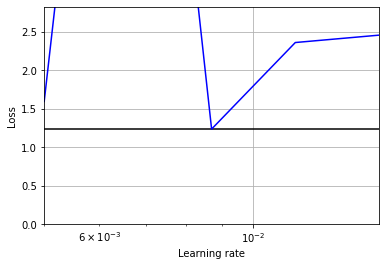

In [ ]:
model = build_model(dropout = 0.25, n_dense = 5, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 5e-3, 
                                   max_rate=2e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 5, 
                    n_neurons = 128, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.008)

history_dropout_nn128_nd5 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 37ms/step - loss: 0.7186 - accuracy: 0.7449 - val_loss: 0.8130 - val_accuracy: 0.6896
Epoch 2/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6750 - accuracy: 0.7663 - val_loss: 0.7269 - val_accuracy: 0.7294
Epoch 3/10
473/473 [==============================] - 17s 35ms/step - loss: 0.7286 - accuracy: 0.7373 - val_loss: 0.7774 - val_accuracy: 0.6996
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7729 - accuracy: 0.7137 - val_loss: 0.9010 - val_accuracy: 0.6829
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.8120 - accuracy: 0.6887 - val_loss: 0.8047 - val_accuracy: 0.6948
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.7831 - accuracy: 0.7041 - val_loss: 0.7713 - val_accuracy: 0.7002
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.7243 - accuracy: 0.7261 - val_loss: 0.7136 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 945ms/step - loss: 1.5978 - accuracy: 0.3438
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.1745 - accuracy: 0.4062
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.2149 - accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 0.8215 - accuracy: 0.6250
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 0.9471 - accuracy: 0.6250


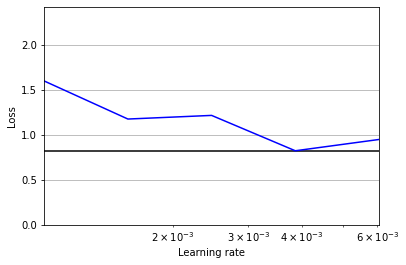

In [ ]:
model = build_model(dropout = 0.25, n_dense = 5, n_neurons = 256, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 1e-3, 
                                   max_rate=9.5e-3)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 5, 
                    n_neurons = 256, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)

history_dropout_nn256_nd5 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.5629 - accuracy: 0.8096 - val_loss: 1.0241 - val_accuracy: 0.7177
Epoch 2/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5111 - accuracy: 0.8306 - val_loss: 0.7387 - val_accuracy: 0.7342
Epoch 3/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5435 - accuracy: 0.8130 - val_loss: 0.7831 - val_accuracy: 0.7211
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5869 - accuracy: 0.7938 - val_loss: 0.7415 - val_accuracy: 0.7378
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6269 - accuracy: 0.7726 - val_loss: 0.6865 - val_accuracy: 0.7434
Epoch 6/10
473/473 [==============================] - 17s 35ms/step - loss: 0.6049 - accuracy: 0.7811 - val_loss: 0.7096 - val_accuracy: 0.7284
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5404 - accuracy: 0.8050 - val_loss: 0.6659 - val_accuracy:

Epoch 1/5
1/1 [==============================] - 1s 878ms/step - loss: 2.1177 - accuracy: 0.2500
Epoch 2/5
1/1 [==============================] - 0s 30ms/step - loss: 1.2663 - accuracy: 0.3438
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 1.4224 - accuracy: 0.4062
Epoch 4/5
1/1 [==============================] - 0s 29ms/step - loss: 1.6853 - accuracy: 0.3438
Epoch 5/5
1/1 [==============================] - 0s 29ms/step - loss: 1.2474 - accuracy: 0.4688


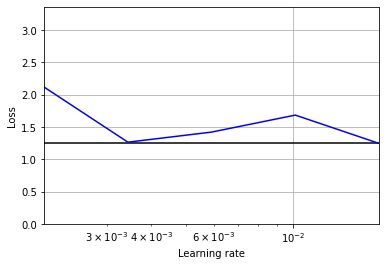

In [ ]:
model = build_model(dropout = 0.25, n_dense = 4, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model, 
                                   train_images, 
                                   train_labels, 
                                   epochs=5,
                                   batch_size=batch_size, 
                                   min_rate = 2e-3, 
                                   max_rate=3e-2)
plot_lr_vs_loss(rates, losses)

In [ ]:
model = build_model(dropout = 0.25, 
                    n_dense = 4, 
                    n_neurons = 128, 
                    activation = 'relu', 
                    initializer = "he_normal")
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 10
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)

history_dropout_nn128_nd4 = model.fit(train_set_augmented, 
                               epochs=10, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/10
473/473 [==============================] - 18s 36ms/step - loss: 0.5937 - accuracy: 0.7942 - val_loss: 0.7892 - val_accuracy: 0.7494
Epoch 2/10
473/473 [==============================] - 17s 37ms/step - loss: 0.5173 - accuracy: 0.8318 - val_loss: 0.8473 - val_accuracy: 0.7372
Epoch 3/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5532 - accuracy: 0.8153 - val_loss: 0.7085 - val_accuracy: 0.7378
Epoch 4/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5948 - accuracy: 0.7890 - val_loss: 0.7129 - val_accuracy: 0.7284
Epoch 5/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6432 - accuracy: 0.7679 - val_loss: 0.6910 - val_accuracy: 0.7288
Epoch 6/10
473/473 [==============================] - 17s 36ms/step - loss: 0.6168 - accuracy: 0.7739 - val_loss: 0.7570 - val_accuracy: 0.7151
Epoch 7/10
473/473 [==============================] - 17s 36ms/step - loss: 0.5551 - accuracy: 0.8024 - val_loss: 0.6863 - val_accuracy:

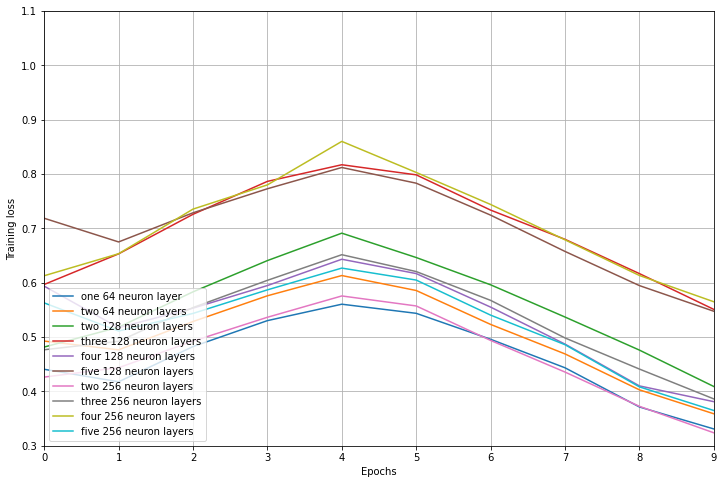

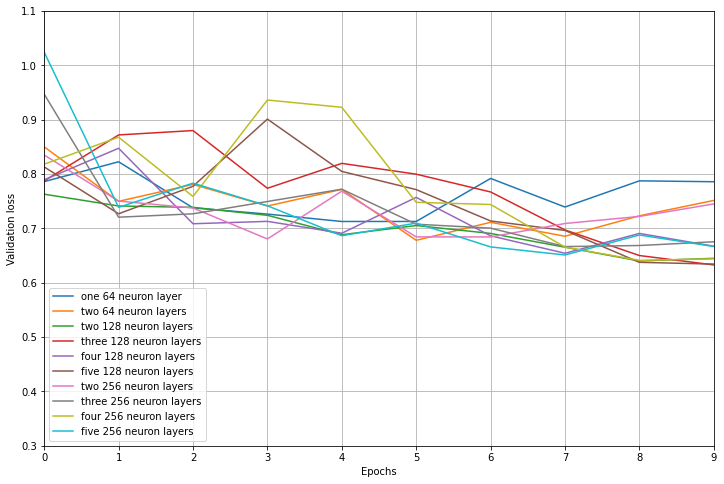

In [ ]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = ["one 64 neuron layer", 
                 "two 64 neuron layers", 
                 "two 128 neuron layers", 
                 "three 128 neuron layers", 
                 "four 128 neuron layers",
                 "five 128 neuron layers",
                 "two 256 neuron layers",
                 "three 256 neuron layers",
                 "four 256 neuron layers",
                 "five 256 neuron layers"
                 ]
    for history, opt_name in zip((history_dropout_nn64_nd1, 
                                  history_dropout_nn64_nd2, 
                                  history_dropout_nn128_nd2,
                                  history_dropout_nn128_nd3,
                                  history_dropout_nn128_nd4,
                                  history_dropout_nn128_nd5,
                                  history_dropout_nn256_nd2,
                                  history_dropout_nn256_nd3,
                                  history_dropout_nn256_nd4,
                                  history_dropout_nn256_nd5 
                                  ),
                                  opt_names):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=1.5)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 
              9, 
              0.3, 
              1.1
              ]
             )
    plt.show()

three or five 128 layers seems to be the way to go. Lets test each of them for 20 epochs.

In [ ]:
model_5_128 = build_model(dropout = 0.25, n_dense = 5, n_neurons = 128, activation = 'relu', initializer = "he_normal")
model_5_128.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.008)

history_dropout_nn128_nd5 = model_5_128.fit(train_set_augmented, 
                               epochs=n_epochs, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/20
473/473 [==============================] - 18s 36ms/step - loss: 0.6786 - accuracy: 0.7669 - val_loss: 0.7680 - val_accuracy: 0.7472
Epoch 2/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6031 - accuracy: 0.8034 - val_loss: 0.7325 - val_accuracy: 0.7344
Epoch 3/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6103 - accuracy: 0.7907 - val_loss: 0.7333 - val_accuracy: 0.7356
Epoch 4/20
473/473 [==============================] - 17s 37ms/step - loss: 0.6473 - accuracy: 0.7727 - val_loss: 0.7010 - val_accuracy: 0.7430
Epoch 5/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6818 - accuracy: 0.7564 - val_loss: 0.7240 - val_accuracy: 0.7203
Epoch 6/20
473/473 [==============================] - 17s 36ms/step - loss: 0.7109 - accuracy: 0.7376 - val_loss: 0.7661 - val_accuracy: 0.7000
Epoch 7/20
473/473 [==============================] - 17s 36ms/step - loss: 0.7419 - accuracy: 0.7202 - val_loss: 0.7770 - val_accuracy:

In [ ]:
model_3_128 = build_model(dropout = 0.25, 
                    n_dense = 3, 
                    n_neurons = 128, 
                    activation = 'relu', 
                    initializer = "he_normal")
model_3_128.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.001),
              metrics=["accuracy"])
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.01)

history_dropout_nn128_nd3 = model_3_128.fit(train_set_augmented, 
                               epochs=n_epochs, 
                               use_multiprocessing=True,
                               validation_data=validation_set_augmented, 
                               callbacks=[onecycle]
                  )

Epoch 1/20
473/473 [==============================] - 18s 36ms/step - loss: 0.5763 - accuracy: 0.8032 - val_loss: 0.7618 - val_accuracy: 0.7432
Epoch 2/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5617 - accuracy: 0.8059 - val_loss: 0.7819 - val_accuracy: 0.7141
Epoch 3/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6188 - accuracy: 0.7830 - val_loss: 0.7081 - val_accuracy: 0.7292
Epoch 4/20
473/473 [==============================] - 17s 35ms/step - loss: 0.6634 - accuracy: 0.7492 - val_loss: 0.7574 - val_accuracy: 0.7259
Epoch 5/20
473/473 [==============================] - 17s 35ms/step - loss: 0.7016 - accuracy: 0.7390 - val_loss: 0.7452 - val_accuracy: 0.7127
Epoch 6/20
473/473 [==============================] - 17s 36ms/step - loss: 0.7379 - accuracy: 0.7212 - val_loss: 0.7332 - val_accuracy: 0.7177
Epoch 7/20
473/473 [==============================] - 17s 36ms/step - loss: 0.7590 - accuracy: 0.7082 - val_loss: 0.7425 - val_accuracy:

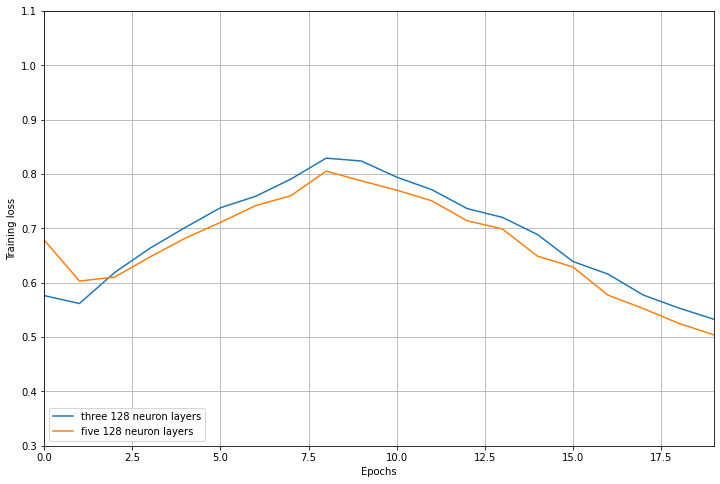

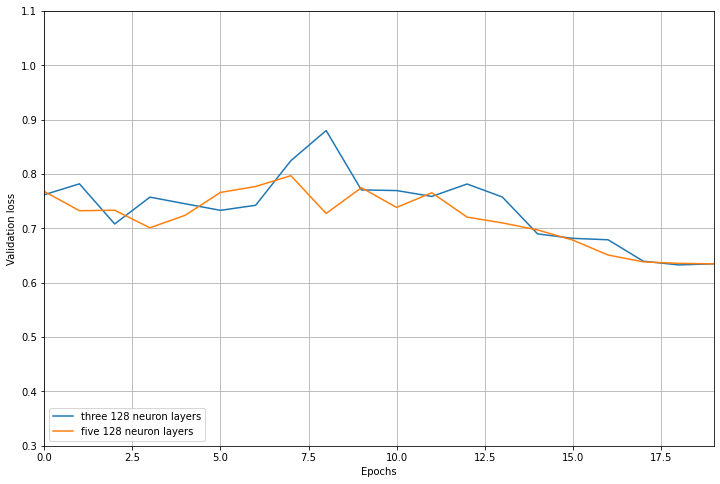

In [105]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = [
                 "three 128 neuron layers",
                 "five 128 neuron layers"
                 ]
    for history, opt_name in zip((
                                  history_dropout_nn128_nd3,
                                  history_dropout_nn128_nd5,
                                  ),
                                  opt_names):
        plt.plot(history.history[loss], 
                 label=f"{opt_name}", 
                 linewidth=1.5)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="lower left")
    plt.axis([0, 
              19, 
              0.3, 
              1.1
              ]
             )
    plt.show()

It looks like the three 128 neuron layers is the way to go as the two architectures have equivalent validation losses at the end of 20 epochs but the three layer architecture is overfitting less. Lets train it for another 20 epochs.

Epoch 1/20
1/1 [==============================] - 1s 817ms/step - loss: 0.5346 - accuracy: 0.7188
Epoch 2/20
1/1 [==============================] - 0s 30ms/step - loss: 0.3880 - accuracy: 0.8125
Epoch 3/20
1/1 [==============================] - 0s 30ms/step - loss: 0.1142 - accuracy: 0.9375
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0218 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 29ms/step - loss: 7.1497e-04 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 28ms/step - loss: 6.6385e-05 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0077 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 27ms/step - loss: 0.1181 - accuracy: 0.9688
Epoch 9/20
1/1 [==============================] - 0s 25ms/step - loss: 1.6391e-07 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 24ms/step - loss: 0.2745 - accuracy: 0.9688
Epoch 11/20
1/1 

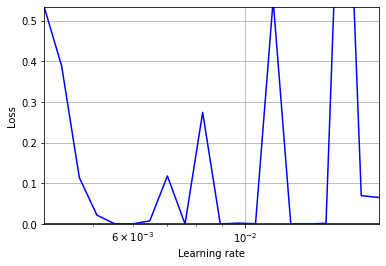

In [110]:
from keras import models
model_3_128_clone = models.clone_model(model_3_128)
model_3_128_clone.set_weights(model_3_128.get_weights())
model_3_128_clone.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
                          metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model_3_128_clone, 
                                   train_images, 
                                   train_labels, 
                                   epochs=20,
                                   batch_size=batch_size, 
                                   min_rate = 4e-3, 
                                   max_rate=.02)
plot_lr_vs_loss(rates, losses)

In [111]:
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.009)

history_dropout_nn128_nd3_2 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5493 - accuracy: 0.7842 - val_loss: 0.6462 - val_accuracy: 0.7476
Epoch 2/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5659 - accuracy: 0.7777 - val_loss: 0.6625 - val_accuracy: 0.7448
Epoch 3/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5802 - accuracy: 0.7758 - val_loss: 0.6557 - val_accuracy: 0.7414
Epoch 4/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6052 - accuracy: 0.7647 - val_loss: 0.6714 - val_accuracy: 0.7448
Epoch 5/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6277 - accuracy: 0.7555 - val_loss: 0.7028 - val_accuracy: 0.7352
Epoch 6/20
473/473 [==============================] - 17s 36ms/step - loss: 0.6584 - accuracy: 0.7476 - val_loss: 0.7984 - val_accuracy: 0.6890
Epoch 7/20
473/473 [==============================] - 17s 36ms/step - loss: 0.7049 - accuracy: 0.7290 - val_loss: 0.7504 - val_accuracy:

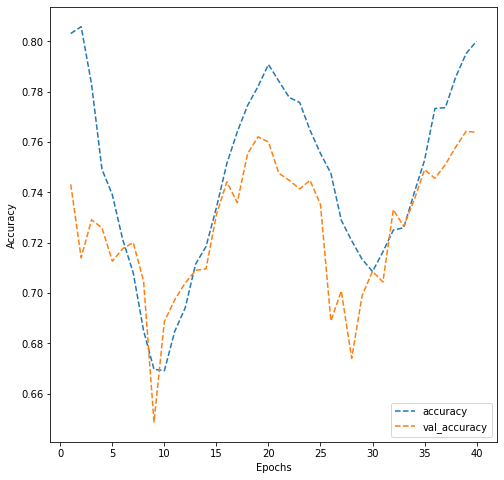

In [112]:
import tensorflow.keras
# Concatenate the two histories along the epoch axis
merged_history = {key: np.concatenate((history_dropout_nn128_nd3.history[key], history_dropout_nn128_nd3_2.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history = tensorflow.keras.callbacks.History()
final_history.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# # Add a vertical line
# class_weights_changed_index = 56
# plt.axvline(x=56, color='k', linestyle='-', label = 'class weights changed at epoch 56', lw=.5)

# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

It looks like it may be prudent to increase the base learning rate because once the learning drops back down at the end of the cycle, the model starts overfitting again.

Epoch 1/20
1/1 [==============================] - 1s 802ms/step - loss: 0.3184 - accuracy: 0.9062
Epoch 2/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0756 - accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0466 - accuracy: 0.9688
Epoch 4/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 28ms/step - loss: 3.7253e-08 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 26ms/step - loss: 0.2345 - accuracy: 0.9688
Epoch 10/20
1/1 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/20
1/1 

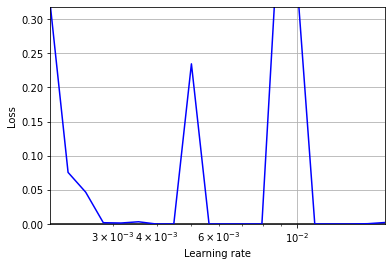

In [126]:
from keras import models
model_3_128_clone = models.clone_model(model_3_128)
model_3_128_clone.set_weights(model_3_128.get_weights())
model_3_128_clone.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.002),
                          metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model_3_128_clone, 
                                   train_images, 
                                   train_labels, 
                                   epochs=20,
                                   batch_size=batch_size, 
                                   min_rate = 2e-3, 
                                   max_rate=.02)
plot_lr_vs_loss(rates, losses)

In [127]:
n_epochs = 20
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.004)
model_3_128.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.002),
              metrics=["accuracy"])
history_dropout_nn128_nd3_3 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/20
473/473 [==============================] - 18s 36ms/step - loss: 0.5166 - accuracy: 0.7978 - val_loss: 0.6441 - val_accuracy: 0.7659
Epoch 2/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5172 - accuracy: 0.7978 - val_loss: 0.6343 - val_accuracy: 0.7619
Epoch 3/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5168 - accuracy: 0.7979 - val_loss: 0.6446 - val_accuracy: 0.7541
Epoch 4/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5217 - accuracy: 0.7965 - val_loss: 0.6212 - val_accuracy: 0.7611
Epoch 5/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5216 - accuracy: 0.7979 - val_loss: 0.6504 - val_accuracy: 0.7599
Epoch 6/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5362 - accuracy: 0.7914 - val_loss: 0.6458 - val_accuracy: 0.7587
Epoch 7/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5539 - accuracy: 0.7874 - val_loss: 0.6478 - val_accuracy:

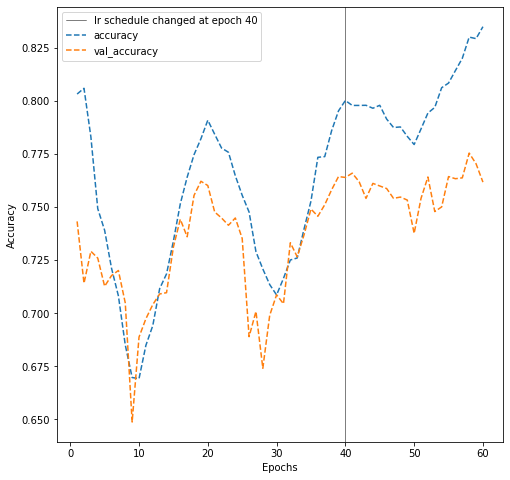

In [128]:
merged_history = {key: np.concatenate((final_history.history[key], history_dropout_nn128_nd3_3.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history_2 = tensorflow.keras.callbacks.History()
final_history_2.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
# class_weights_changed_index = 56
plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)

# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

Lets further increase lr and decrease the cycle length.

Epoch 1/15
1/1 [==============================] - 1s 858ms/step - loss: 0.5193 - accuracy: 0.8125
Epoch 2/15
1/1 [==============================] - 0s 29ms/step - loss: 0.4927 - accuracy: 0.8438
Epoch 3/15
1/1 [==============================] - 0s 29ms/step - loss: 0.1860 - accuracy: 0.9062
Epoch 4/15
1/1 [==============================] - 0s 29ms/step - loss: 0.2161 - accuracy: 0.9062
Epoch 5/15
1/1 [==============================] - 0s 29ms/step - loss: 0.6008 - accuracy: 0.8125
Epoch 6/15
1/1 [==============================] - 0s 28ms/step - loss: 0.0885 - accuracy: 1.0000
Epoch 7/15
1/1 [==============================] - 0s 30ms/step - loss: 0.0635 - accuracy: 0.9688
Epoch 8/15
1/1 [==============================] - 0s 29ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 9/15
1/1 [==============================] - 0s 24ms/step - loss: 30.2702 - accuracy: 0.7500
Epoch 10/15
1/1 [==============================] - 0s 24ms/step - loss: 0.2277 - accuracy: 0.9375
Epoch 11/15
1/1 [==========

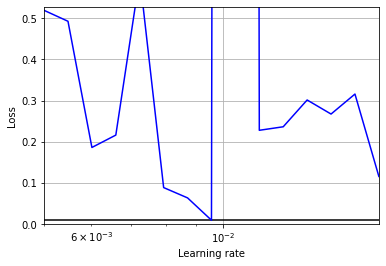

In [132]:
from keras import models
model_3_128_clone = models.clone_model(model_3_128)
model_3_128_clone.set_weights(model_3_128.get_weights())
model_3_128_clone.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.003),
                          metrics=["accuracy"])
batch_size = 128
train_images, train_labels = next(train_set_augmented)
rates, losses = find_learning_rate(model_3_128_clone, 
                                   train_images, 
                                   train_labels, 
                                   epochs=15,
                                   batch_size=batch_size, 
                                   min_rate = 5e-3, 
                                   max_rate=2e-2)
plot_lr_vs_loss(rates, losses)

In [133]:
n_epochs = 15
onecycle = OneCycleScheduler(473 * n_epochs,
                             max_lr=0.009)
model_3_128.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.003),
              metrics=["accuracy"])
history_dropout_nn128_nd3_4 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/15
473/473 [==============================] - 18s 37ms/step - loss: 0.4810 - accuracy: 0.8151 - val_loss: 0.6463 - val_accuracy: 0.7599
Epoch 2/15
473/473 [==============================] - 17s 35ms/step - loss: 0.4867 - accuracy: 0.8140 - val_loss: 0.6778 - val_accuracy: 0.7559
Epoch 3/15
473/473 [==============================] - 17s 36ms/step - loss: 0.5316 - accuracy: 0.7959 - val_loss: 0.7108 - val_accuracy: 0.7380
Epoch 4/15
473/473 [==============================] - 17s 35ms/step - loss: 0.5616 - accuracy: 0.7839 - val_loss: 0.6706 - val_accuracy: 0.7509
Epoch 5/15
473/473 [==============================] - 17s 35ms/step - loss: 0.6233 - accuracy: 0.7618 - val_loss: 0.7109 - val_accuracy: 0.7195
Epoch 6/15
473/473 [==============================] - 17s 35ms/step - loss: 0.6578 - accuracy: 0.7464 - val_loss: 0.7127 - val_accuracy: 0.7267
Epoch 7/15
473/473 [==============================] - 17s 35ms/step - loss: 0.7104 - accuracy: 0.7250 - val_loss: 0.7218 - val_accuracy:

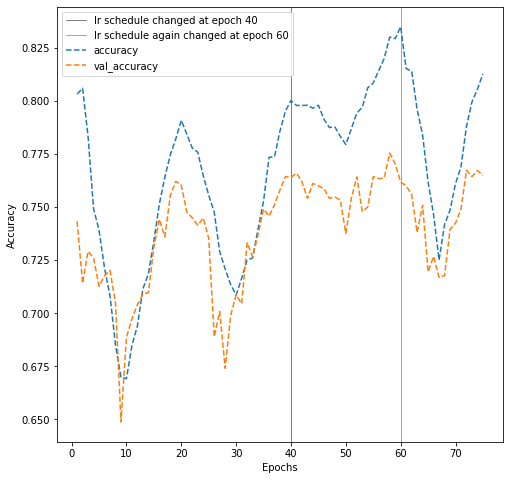

In [136]:
merged_history = {key: np.concatenate((final_history_2.history[key], history_dropout_nn128_nd3_4.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history_3 = tensorflow.keras.callbacks.History()
final_history_3.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
# class_weights_changed_index = 56
plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)


# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [142]:
model_3_128.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adamax(0.007),
              metrics=["accuracy"])
history_dropout_nn128_nd3_6 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=5, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              #callbacks=[onecycle]
                                              )

Epoch 1/5
473/473 [==============================] - 19s 37ms/step - loss: 0.8134 - accuracy: 0.6730 - val_loss: 0.7259 - val_accuracy: 0.7221
Epoch 2/5
473/473 [==============================] - 17s 37ms/step - loss: 0.7000 - accuracy: 0.7274 - val_loss: 0.7484 - val_accuracy: 0.7221
Epoch 3/5
473/473 [==============================] - 17s 36ms/step - loss: 0.6823 - accuracy: 0.7363 - val_loss: 0.7228 - val_accuracy: 0.7085
Epoch 4/5
473/473 [==============================] - 17s 36ms/step - loss: 0.6899 - accuracy: 0.7352 - val_loss: 0.7121 - val_accuracy: 0.7195
Epoch 5/5
473/473 [==============================] - 17s 35ms/step - loss: 0.6789 - accuracy: 0.7366 - val_loss: 0.6968 - val_accuracy: 0.7288


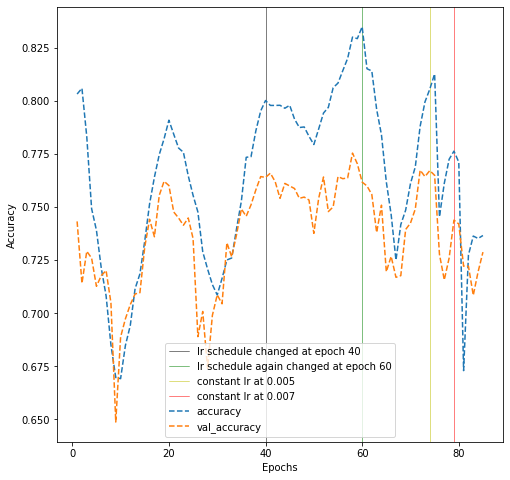

In [178]:
merged_history = {key: np.concatenate((final_history_4.history[key], history_dropout_nn128_nd3_6.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history_5 = tensorflow.keras.callbacks.History()
final_history_5.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
# class_weights_changed_index = 56
plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)
plt.axvline(x=74, color='y', linestyle='-', label = 'constant lr at 0.005', lw=.5)
plt.axvline(x=79, color='r', linestyle='-', label = 'constant lr at 0.007', lw=.5)




# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [14]:
class OneCycleScheduler1(keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
      if self.iteration < self.half_iteration:
        lr = self._interpolate(0, 
                                self.half_iteration, 
                                self.start_lr,
                                self.max_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)
      elif self.iteration < 2 * self.half_iteration:
        lr = self._interpolate(self.half_iteration, 
                                2 * self.half_iteration,
                                self.max_lr, 
                                self.start_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)
      # else:
      #     lr = self._interpolate(2 * self.half_iteration, 
      #                             self.iterations,
      #                             self.start_lr, 
      #                             self.last_lr)
      

In [185]:
# model_3_128_clone = models.clone_model(model_3_128)
# model_3_128_clone.set_weights(model_3_128.get_weights())
# model_3_128_clone.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(0.001),
#                           metrics=["accuracy"])
n_epochs = 15
onecycle = OneCycleScheduler1(473 * n_epochs,
                             max_lr=0.01)
history_dropout_nn128_nd3_7 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=15, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/15
473/473 [==============================] - 17s 36ms/step - loss: 0.5608 - accuracy: 0.7827 - val_loss: 0.6718 - val_accuracy: 0.7494
Epoch 2/15
473/473 [==============================] - 17s 36ms/step - loss: 0.5598 - accuracy: 0.7862 - val_loss: 0.6903 - val_accuracy: 0.7539
Epoch 3/15
473/473 [==============================] - 17s 35ms/step - loss: 0.5569 - accuracy: 0.7832 - val_loss: 0.6768 - val_accuracy: 0.7539
Epoch 4/15
473/473 [==============================] - 17s 35ms/step - loss: 0.6131 - accuracy: 0.7622 - val_loss: 0.6939 - val_accuracy: 0.7430
Epoch 5/15
473/473 [==============================] - 18s 37ms/step - loss: 0.6506 - accuracy: 0.7505 - val_loss: 0.7457 - val_accuracy: 0.7269
Epoch 6/15
473/473 [==============================] - 17s 36ms/step - loss: 0.6790 - accuracy: 0.7382 - val_loss: 0.7610 - val_accuracy: 0.7189
Epoch 7/15
473/473 [==============================] - 17s 35ms/step - loss: 0.6901 - accuracy: 0.7364 - val_loss: 0.7576 - val_accuracy:

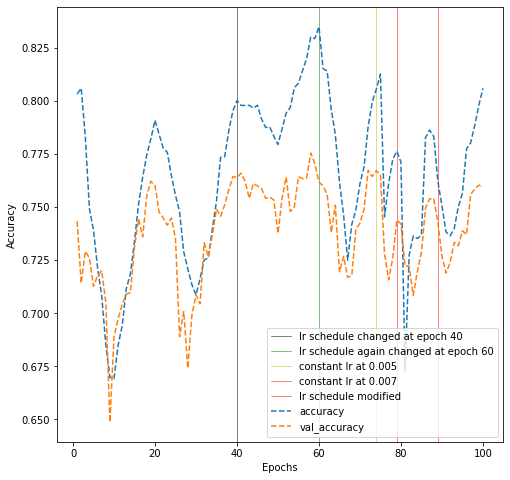

In [186]:
merged_history = {key: np.concatenate((final_history_5.history[key], history_dropout_nn128_nd3_7.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history_6 = tensorflow.keras.callbacks.History()
final_history_6.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
# class_weights_changed_index = 56
plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)
plt.axvline(x=74, color='y', linestyle='-', label = 'constant lr at 0.005', lw=.5)
plt.axvline(x=79, color='r', linestyle='-', label = 'constant lr at 0.007', lw=.5)
plt.axvline(x=89, color='r', linestyle='-', label = 'lr schedule modified', lw=.5)





# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [189]:
n_epochs = 20
onecycle = OneCycleScheduler1(473 * n_epochs,
                             max_lr=0.01)
history_dropout_nn128_nd3_8 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5024 - accuracy: 0.8034 - val_loss: 0.6743 - val_accuracy: 0.7639
Epoch 2/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5066 - accuracy: 0.8063 - val_loss: 0.6413 - val_accuracy: 0.7631
Epoch 3/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5398 - accuracy: 0.7903 - val_loss: 0.6572 - val_accuracy: 0.7557
Epoch 4/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5476 - accuracy: 0.7926 - val_loss: 0.6559 - val_accuracy: 0.7474
Epoch 5/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5700 - accuracy: 0.7807 - val_loss: 0.6684 - val_accuracy: 0.7521
Epoch 6/20
473/473 [==============================] - 18s 37ms/step - loss: 0.5942 - accuracy: 0.7738 - val_loss: 0.6488 - val_accuracy: 0.7579
Epoch 7/20
473/473 [==============================] - 17s 36ms/step - loss: 0.5984 - accuracy: 0.7701 - val_loss: 0.7084 - val_accuracy:

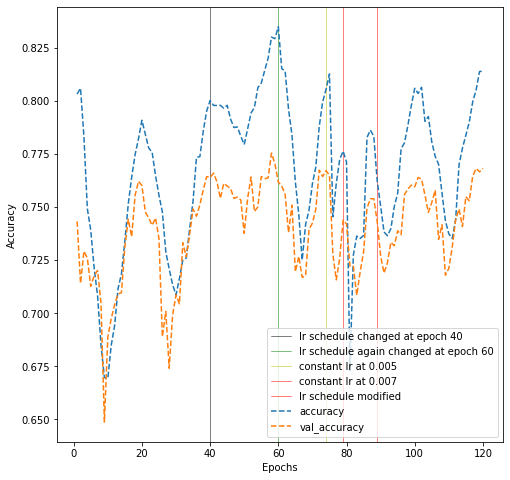

In [191]:
merged_history = {key: np.concatenate((final_history_6.history[key], history_dropout_nn128_nd3_8.history[key]), axis=0) 
                  for key in history.history.keys()}

# Create a new history object from the merged data
final_history_7 = tensorflow.keras.callbacks.History()
final_history_7.history = merged_history
dict_hist = merged_history

list_ep = [i for i in range(1, len(dict_hist['accuracy'])+1)]

plt.figure(figsize = (8, 8))

# Add a vertical line
# class_weights_changed_index = 56
plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)
plt.axvline(x=74, color='y', linestyle='-', label = 'constant lr at 0.005', lw=.5)
plt.axvline(x=79, color='r', linestyle='-', label = 'constant lr at 0.007', lw=.5)
plt.axvline(x=89, color='r', linestyle='-', label = 'lr schedule modified', lw=.5)





# Show the plot

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

Lets try checking how the model is performing on the test data. 

In [19]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              batch_size = 128,
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              shuffle = True) 
model_3_128.evaluate(test_set)

Found 128 images belonging to 4 classes.
1/1 [==============================] - 11s 11s/step - loss: 1.0295 - accuracy: 0.5547


[1.0294721126556396, 0.5546875]

4/4 [==============================] - 10s 3s/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.21      0.22      0.21        32
           2       0.18      0.16      0.17        32
           3       0.94      0.94      0.94        32

    accuracy                           0.55       128
   macro avg       0.54      0.55      0.55       128
weighted avg       0.54      0.55      0.55       128



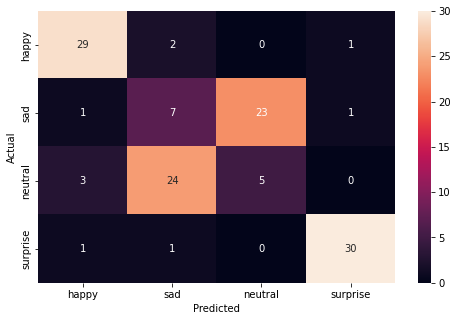

In [20]:
test_images, test_labels = next(test_set)

pred = model_3_128.predict(test_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
metrics_score(y_true, pred)

A tiny bit better. Lets try training on both precision and accuracy this time and see if that helps.

In [15]:
n_epochs = 20
onecycle = OneCycleScheduler1(473 * n_epochs,
                             max_lr=0.01)
model_3_128.compile(optimizer = 'adamax', loss = 'categorical_crossentropy', metrics = ['accuracy', 'Precision'])
history_dropout_nn128_nd3_9 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/20
473/473 [==============================] - 81s 150ms/step - loss: 0.4947 - accuracy: 0.8112 - precision: 0.8365 - val_loss: 0.6783 - val_accuracy: 0.7657 - val_precision: 0.8021
Epoch 2/20
473/473 [==============================] - 68s 145ms/step - loss: 0.4930 - accuracy: 0.8132 - precision: 0.8403 - val_loss: 0.6630 - val_accuracy: 0.7629 - val_precision: 0.7954
Epoch 3/20
473/473 [==============================] - 69s 145ms/step - loss: 0.5060 - accuracy: 0.8085 - precision: 0.8341 - val_loss: 0.6539 - val_accuracy: 0.7697 - val_precision: 0.8035
Epoch 4/20
473/473 [==============================] - 69s 146ms/step - loss: 0.5550 - accuracy: 0.7911 - precision: 0.8201 - val_loss: 0.6649 - val_accuracy: 0.7523 - val_precision: 0.7830
Epoch 5/20
473/473 [==============================] - 69s 146ms/step - loss: 0.5374 - accuracy: 0.7949 - precision: 0.8247 - val_loss: 0.7681 - val_accuracy: 0.7440 - val_precision: 0.7749
Epoch 6/20
473/473 [==============================] - 6

1/1 [==============================] - 2s 2s/step - loss: 1.2515 - accuracy: 0.5547 - precision: 0.5847
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        32
           1       0.24      0.28      0.26        32
           2       0.18      0.16      0.17        32
           3       0.94      0.91      0.92        32

    accuracy                           0.55       128
   macro avg       0.56      0.55      0.56       128
weighted avg       0.56      0.55      0.56       128



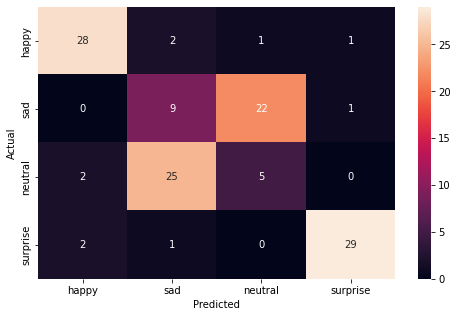

In [33]:
evaluate_on_testset(model_3_128)

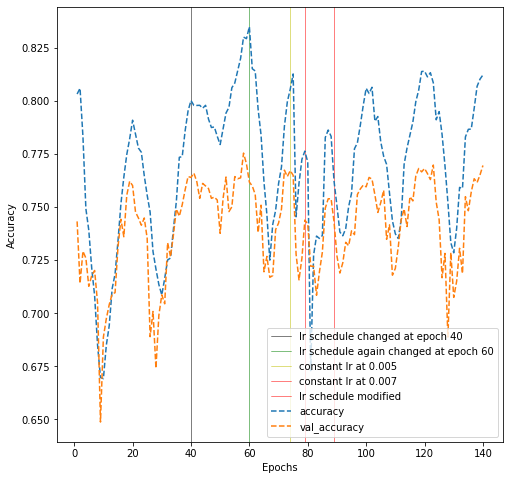

In [53]:
final_history_8 = show_history(final_history_7, history_dropout_nn128_nd3_9)

In [54]:
import keras
n_epochs = 20
onecycle = OneCycleScheduler1(473 * n_epochs,
                             max_lr=0.01)
model_3_128.compile(optimizer = keras.optimizers.Adamax(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'Recall'])
history_dropout_nn128_nd3_10 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/20
473/473 [==============================] - 71s 147ms/step - loss: 0.5033 - accuracy: 0.8095 - recall: 0.7787 - val_loss: 0.6929 - val_accuracy: 0.7501 - val_recall: 0.7048
Epoch 2/20
473/473 [==============================] - 69s 145ms/step - loss: 0.4998 - accuracy: 0.8074 - recall: 0.7762 - val_loss: 0.7813 - val_accuracy: 0.7585 - val_recall: 0.7191
Epoch 3/20
473/473 [==============================] - 69s 145ms/step - loss: 0.5076 - accuracy: 0.8093 - recall: 0.7761 - val_loss: 0.6841 - val_accuracy: 0.7521 - val_recall: 0.7131
Epoch 4/20
473/473 [==============================] - 69s 145ms/step - loss: 0.5281 - accuracy: 0.8018 - recall: 0.7654 - val_loss: 0.7387 - val_accuracy: 0.7474 - val_recall: 0.7064
Epoch 5/20
473/473 [==============================] - 70s 147ms/step - loss: 0.5445 - accuracy: 0.7958 - recall: 0.7592 - val_loss: 0.7258 - val_accuracy: 0.7432 - val_recall: 0.7020
Epoch 6/20
473/473 [==============================] - 69s 146ms/step - loss: 0.5787 -

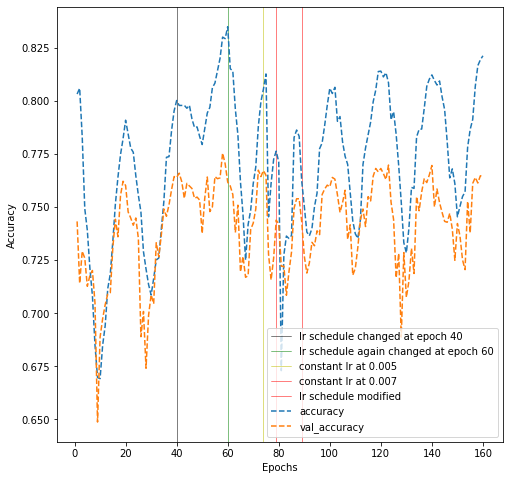

In [58]:
final_history_9 = show_history(final_history_8, history_dropout_nn128_nd3_10)

1/1 [==============================] - 0s 131ms/step - loss: 1.0626 - accuracy: 0.5703 - recall: 0.5625
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        32
           1       0.26      0.28      0.27        32
           2       0.19      0.16      0.17        32
           3       0.94      0.94      0.94        32

    accuracy                           0.57       128
   macro avg       0.55      0.57      0.56       128
weighted avg       0.55      0.57      0.56       128



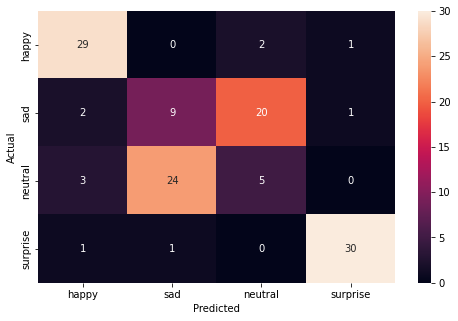

In [59]:
evaluate_on_testset(model_3_128)

Recall and accuracy improved. Lets try a longer training cycle on all three metrics.

In [60]:
n_epochs = 50
onecycle = OneCycleScheduler1(473 * n_epochs,
                             max_lr=0.01)
model_3_128.compile(optimizer = keras.optimizers.Adamax(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy', 'Recall', 'Precision'])
history_dropout_nn128_nd3_11 = model_3_128.fit(
                                              train_set_augmented, 
                                              epochs=n_epochs, 
                                              use_multiprocessing=True,
                                              validation_data=validation_set_augmented, 
                                              callbacks=[onecycle]
                                              )

Epoch 1/50
473/473 [==============================] - 71s 148ms/step - loss: 0.4896 - accuracy: 0.8088 - recall: 0.7772 - precision: 0.8373 - val_loss: 0.7052 - val_accuracy: 0.7659 - val_recall: 0.7193 - val_precision: 0.8025
Epoch 2/50
473/473 [==============================] - 70s 147ms/step - loss: 0.4932 - accuracy: 0.8103 - recall: 0.7767 - precision: 0.8381 - val_loss: 0.6668 - val_accuracy: 0.7679 - val_recall: 0.7310 - val_precision: 0.7983
Epoch 3/50
473/473 [==============================] - 69s 145ms/step - loss: 0.4877 - accuracy: 0.8177 - recall: 0.7882 - precision: 0.8423 - val_loss: 0.6539 - val_accuracy: 0.7641 - val_recall: 0.7181 - val_precision: 0.7990
Epoch 4/50
473/473 [==============================] - 69s 145ms/step - loss: 0.4774 - accuracy: 0.8186 - recall: 0.7881 - precision: 0.8442 - val_loss: 0.6769 - val_accuracy: 0.7641 - val_recall: 0.7151 - val_precision: 0.8023
Epoch 5/50
473/473 [==============================] - 69s 146ms/step - loss: 0.4951 - accura

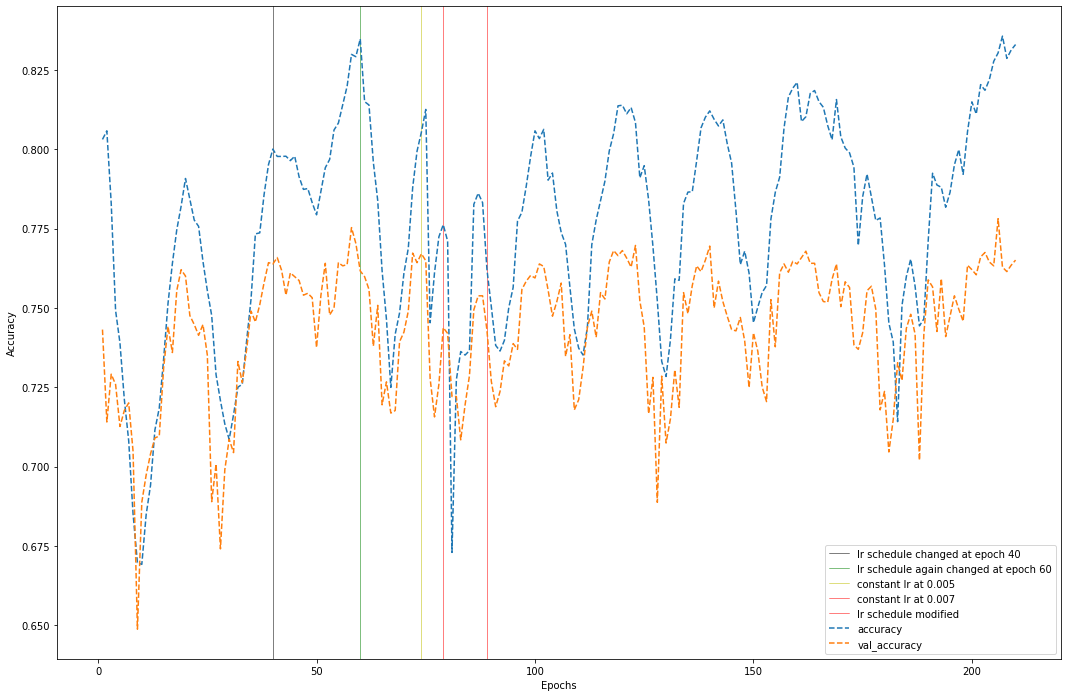

In [65]:
final_history_10 = show_history(final_history_9, history_dropout_nn128_nd3_11)

1/1 [==============================] - 0s 126ms/step - loss: 1.1790 - accuracy: 0.5547 - recall: 0.5469 - precision: 0.5833
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        32
           1       0.21      0.22      0.21        32
           2       0.19      0.19      0.19        32
           3       0.94      0.91      0.92        32

    accuracy                           0.55       128
   macro avg       0.56      0.55      0.56       128
weighted avg       0.56      0.55      0.56       128



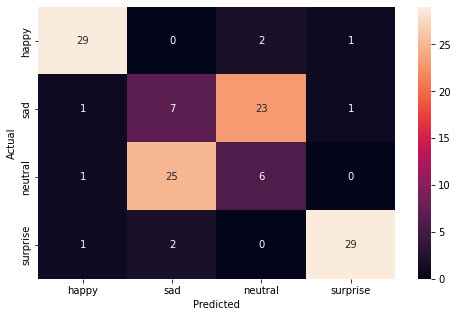

In [66]:
evaluate_on_testset(model_3_128)

In [32]:
datagen_test = ImageDataGenerator(rescale=1./255)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                                              target_size = (img_size,img_size),
                                                              color_mode = 'grayscale',
                                                              class_mode = 'categorical',
                                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                                              batch_size = 128,
                                                              shuffle = True) 
def evaluate_on_testset(model = None):
  test_images, test_labels = next(test_set)
  if model == None:
    pass
  pred = model.predict(test_images)
  pred = np.argmax(pred, axis = 1) 
  y_true = np.argmax(test_labels, axis = 1)
  model.evaluate(test_set)
  metrics_score(y_true, pred)


Found 128 images belonging to 4 classes.


In [64]:
def show_history(old_history=None, new_history = None):
  #hist_df_old = pd.DataFrame(old_history) #I'll at some point make this a little more datatype-agnostic - uncomment or edit to adapt to different datatypes
  hist_df_new = pd.DataFrame(new_history.history)
  merged_history = pd.concat((old_history, hist_df_new), axis=0)


  list_ep = [i for i in range(1, len(merged_history)+1)]

  plt.figure(figsize = (18, 12))

  # Add a vertical line
  # class_weights_changed_index = 56
  plt.axvline(x=40, color='k', linestyle='-', label = 'lr schedule changed at epoch 40', lw=.5)
  plt.axvline(x=60, color='g', linestyle='-', label = 'lr schedule again changed at epoch 60', lw=.5)
  plt.axvline(x=74, color='y', linestyle='-', label = 'constant lr at 0.005', lw=.5)
  plt.axvline(x=79, color='r', linestyle='-', label = 'constant lr at 0.007', lw=.5)
  plt.axvline(x=89, color='r', linestyle='-', label = 'lr schedule modified', lw=.5)





  # Show the plot

  plt.plot(list_ep, merged_history['accuracy'], ls = '--', label = 'accuracy')

  plt.plot(list_ep, merged_history['val_accuracy'], ls = '--', label = 'val_accuracy')

  plt.ylabel('Accuracy')

  plt.xlabel('Epochs')

  plt.legend()

  plt.show()
  return merged_history


In [76]:
model_3_128.save("/content/gdrive/My Drive/model_3_128.h5")


In [201]:
hist_df = pd.DataFrame(history.history) 

In [72]:
final_history_10.to_csv("final history_10.csv")

In [18]:
df = pd.read_csv('final_history_7.csv', index_col=0, squeeze = True)
final_history_7 = df.to_dict()

In [74]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


To come next: figuring out this learning schedule and also just training the network on 'sad' and 'neutral.'